# Import packages #

In [1]:
# Packages that may need to be installed
# !pip install iminuit
# !pip install mplhep
# !pip install functools
# !pip install seaborn

In [2]:
import logging
import pandas as pd
import matplotlib.pyplot as plt
import mplhep as hep
import numpy as np
import seaborn as sns
from iminuit import Minuit
from functools import partial
logging.getLogger("iminuit").setLevel(logging.WARNING)
plt.style.use(hep.style.CMS)

# The problem #

### Finding Higgs decaying to $\tau$ leptons ###

The purpose of this mini project is to separate a signal (S) of Higgs bosons decaying to $\tau$ leptons from a much bigger background (B) of $Z$ bosons decaying to $\tau$ leptons i.e. to separate the processes shown below:

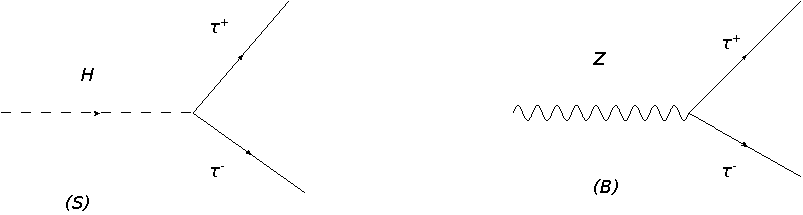

The $\tau$ leptons can then decay hadronically (h) or leptonically - so either an electron (e) or a muon ($\mu$) as shown in the  below:

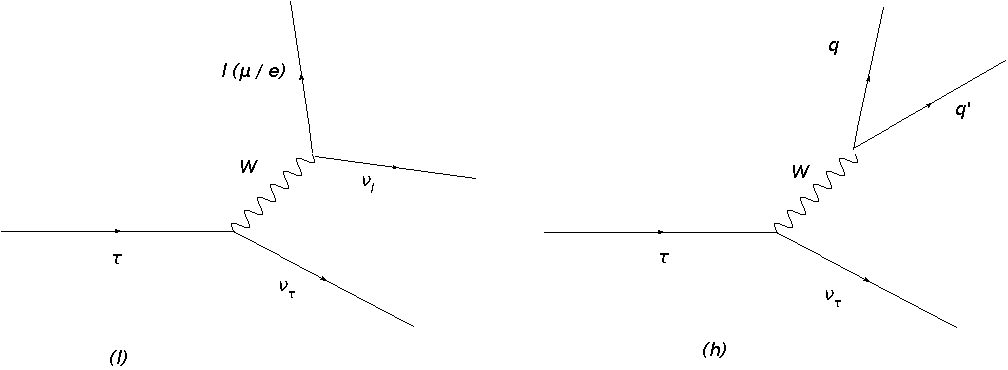

Now the Z boson has a mass of ~90GeV and the Higgs boson a mass of ~125GeV so naively you would think that this would be easy as you could just reconstruct all the particles and find the invarient mass. However, the problem is that we cannot reconstruct any of the neutrinos ($\nu$), so we have to use other variables as well.

## Production mode ##

There is a slight complication in that the Higgs can be produced in different ways. The most likely two being gluon fusion (ggH) and vector boson fusion (VBF). With ggH happening about 10 the rate of VBF, however VBF events have some topological structures that might help to identify them. The processes are shown below:

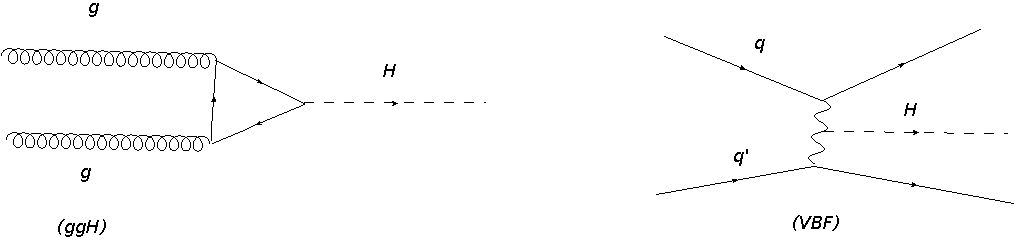



Z bosons can also be produced in different ways but the dominate way is through a Drell-Yan process (DY).

### About 2000 Z bosons are produced for every Higgs boson that is produced ###

## The assignment ##

We want you to use simulated events to try to optimise a search for the signal Higgs bosons. To do this you will need to attempt to separate the signal Higgs boson events from the background Z boson events. We will give you events separated by decay channels:  where one $\tau$ has decayed to an electron and the other hadronically (et), where one $\tau$ has decayed to a $\mu$ and the other hadronically (mt), and where both have decayed hadronically (tt). We will give you samples for different processes i.e. Z bosons (DY), Higgs from ggH and Higgs from VBF. In each of these datasets we will give a series of event variables which will explained below.

Your assignment is to produce a binning of the dataset that provides the most precise measurement of the rate you expect the signal process to occur. This is done by looking at the uncertainty you get when performing an extended binned likelihood fit to your binned dataset. The bins should be chosen by using the output of a machine learning algorithm.

The following code reads in the data into pandas dataframes (**Farhan**: I have already these in once and saved them locally for faster retrieval.)

In [3]:
channels = ["et","mt","tt"]
processes = ["DY","ggH","VBF"]

dataset = {}
for channel in channels:
  dataset[channel] = {}
  for process in processes:
    url = f"https://raw.githubusercontent.com/gputtley/ML-Assessment-3/master/{channel}_{process}.pkl"
    dataset[channel][process] = pd.read_pickle(url)

In [4]:
for channel in channels:
    for process in processes:
        dataset[channel][process].to_csv(f'{channel}_{process}.csv', sep = ',', encoding = 'utf-8')

An example of the tt channel DY events are shown below.

In [5]:
display(dataset["tt"]["DY"])

,dR,dijetpt,dphi,eta_1,eta_2,jdeta,jpt_1,jpt_2,m_vis,met,...,mva_dm_2,n_deepbjets,n_jets,pt_1,pt_2,pt_tt,pt_vis,q_1,q_2,svfit_mass
0,2.414482,-9999.000000,2.373276,0.288935,-0.155231,-9999.000000,42.114372,-9999.000000,86.581536,30.150600,...,1.0,0.0,1.0,48.971975,42.047497,56.198355,34.711005,1.0,-1.0,122.340492
1,0.905428,105.572952,-0.870895,-1.301026,-1.053353,0.309145,202.115177,155.836621,47.121035,74.118637,...,0.0,0.0,3.0,67.624255,42.424370,167.510356,100.343648,-1.0,1.0,81.164604
2,1.786701,-9999.000000,-1.725332,-1.701998,-1.237745,-9999.000000,81.649279,-9999.000000,68.659531,24.880594,...,1.0,0.0,1.0,43.318895,43.055293,77.721734,56.179411,-1.0,1.0,90.083839
3,3.261100,-9999.000000,-3.132327,0.415204,-0.492155,-9999.000000,-9999.000000,-9999.000000,272.676875,79.535843,...,10.0,0.0,0.0,161.267835,94.447914,12.772213,66.829704,1.0,-1.0,394.964371
4,2.808269,44.089321,2.768047,-0.933327,-1.406919,0.360274,51.960214,24.052974,110.202417,13.298456,...,1.0,0.0,1.0,71.982552,41.230914,23.789963,36.810342,-1.0,1.0,121.641335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10554,2.434000,-9999.000000,-2.364294,-0.703203,-1.281535,-9999.000000,39.474594,-9999.000000,84.618685,10.248204,...,10.0,0.0,1.0,45.458845,41.776954,43.308454,33.232148,-1.0,1.0,103.120327
10555,0.650817,321.734161,-0.201372,0.496136,1.115016,0.998327,297.371251,40.722552,59.738937,107.629318,...,2.0,0.0,2.0,115.287050,70.994218,290.712892,185.391304,-1.0,1.0,86.510059
10556,1.468973,129.886017,1.302548,0.315466,0.994619,3.097943,163.557993,59.898794,89.913374,55.855453,...,2.0,0.0,3.0,74.985983,55.278327,149.554641,104.287329,1.0,-1.0,133.496468
10557,3.096478,-9999.000000,3.002873,0.769950,0.014352,-9999.000000,-9999.000000,-9999.000000,148.423309,33.579464,...,2.0,0.0,0.0,71.921759,66.870102,23.317015,10.859038,-1.0,1.0,163.827553


## Variables definitions
If a variable shown below ends with {1,2}, this means that the variable exists for both the tau decay products 1 and 2. 1 refers to the leading transverse momentum hadronic tau in tt channel and the electron or muon in the et or mt channel. 2 refers to the subleading transverse momentum hadronic tau in tt channel and the hadronic tau in the et and mt channel. Any variable that takes the value -9999 is undefined for that event.

- dR: Distance between the two tau decay products.
- dijetpt: Total transverse momentum of the two highest transverse momentum jets in the event.
- dphi: The angle phi between the two tau decay products.
- eta_{1,2}: The detector eta of the tau decay products.
- jdeta: The eta between the two highest transverse momentum jets in the event.
- jpt_1: The transverse momentum of the leading transverse momentum jet in the event.
- jpt_2: The transverse momentum of the subleading transverse momentum jet in the event.
- m_vis: The reconstructed mass of the visibile ditau decay products.
- met: The missing transverse energy in the event.
- met_dphi_{1,2}: The angle phi between the met and the tau decay product.
- mjj: The reconstructed mass of the two highest transverse momentum jets in the event.
- mt_{1,2}: The transverse mass between the met and the tau decay product.
- mt_lep: The transverse mass between the two tau decay products.
- mt_tot: The sum in quadrature of mt_1, mt_2 and mt_lep.
- mva_dm_{1,2}: The predicted decay mode of the hadronic tau (1 only available for tt channel).
- n_deepbjets: The number of b tagged jets in the event.
- n_jets: The number of jets in the events.
- pt_{1,2}: The transverse momentum of the tau decay product.
- pt_tt: The reconstructed ditau + met transverse momentum.
- pt_vis: The reconstructed ditau transverse momentum.
- q_{1,2}: The charge of the tau decay product.
- svfit_mass: A likihood reconstruction of the ditau mass.

# Binned likelihood class

In [6]:
class BinnedLikelihoodFit:
  """
  A class to perform a binned likelihood fit for different datasets in a physics context.

  Attributes:
      dataset (dict): A dictionary containing the datasets for 'DY', 'ggH', and 'VBF'.
      DY_scaler (float): Scaling factor for the DY dataset.
      ggH_scaler (float): Scaling factor for the ggH dataset.
      VBF_scaler (float): Scaling factor for the VBF dataset.
      fractional_stat_threshold (float): Maximum allowed fractional statistical uncertainty for a bin.
      obs_mu_ggH (float): Observed signal strength for the ggH process.
      obs_mu_VBF (float): Observed signal strength for the VBF process.
      tolerance (float): Tolerance for the fitting procedure.
      initial_guess (float): Initial guess for the fit parameters.
  """
  def __init__(self, DY_dataset, ggH_dataset, VBF_dataset):
    """
    Initializes the BinnedLikelihoodFit class with the provided datasets.

    Parameters:
        DY_dataset (DataFrame): The dataset for DY processes.
        ggH_dataset (DataFrame): The dataset for ggH processes.
        VBF_dataset (DataFrame): The dataset for VBF processes.
    """
    # Store dataset
    self.dataset = {
        "DY" : DY_dataset,
        "ggH" : ggH_dataset,
        "VBF" : VBF_dataset
    }

    # These are the scaling values to correctly account for the balances between the sample. Do not change these.
    self.DY_scaler = 8.4
    self.ggH_scaler = 0.034
    self.VBF_scaler = 0.011

    # Maximum fractional stat uncertainty a bin is allowed to be. Do not change this.
    self.fractional_stat_threshold = 0.2

    # Observed mu
    self.obs_mu_ggH = 1.0
    self.obs_mu_VBF = 1.0

    # Fitting parameters
    self.tolerance = 0.001
    self.initial_guess = 0.0

  def _check_orthogonality(self, categories):
    """
    Checks whether the specified categories are orthogonal across all datasets.

    Parameters:
        categories (list): List of category query strings.

    Returns:
        bool: True if categories are orthogonal, False otherwise.
    """
    for dataset_name, dataset in self.dataset.items():
      dataset = dataset.copy()
      dataset.loc[:,"index"] = range(len(dataset))
      seen_indices = set()
      for cat in categories:
        if cat is not None:
          tmp_indices = set(dataset.query(cat).loc[:,"index"])
        else:
          tmp_indices = set(dataset.loc[:,"index"])
        if seen_indices & tmp_indices:
          print(f"Categories {categories} are not orthogonal.")
          return False
        seen_indices.update(tmp_indices)
    return True

  def _check_statistics(self, hist, uncert):
    """
    Checks the statistical validity of the provided histogram and uncertainties.

    Parameters:
        hist (array): Histogram values.
        uncert (array): Corresponding uncertainties for the histogram.

    Returns:
        bool: True if all bins meet the statistical criteria, False otherwise.
    """
    for bin, val in enumerate(hist):
      if uncert[bin]/val > self.fractional_stat_threshold:
        print(f"Fractional statistical sample of bin {bin} too small. It is {uncert[bin]/val} and needs to be greater than {self.fractional_stat_threshold}. Consider using coarser bins.")
        return False
    return True

  def _get_combined_histogram(self, hist_DY, hist_ggH, hist_VBF, mu_ggH, mu_VBF):
    """
    Combines individual histograms into a single histogram based on scaling factors.

    Parameters:
        hist_DY (array): Histogram for DY processes.
        hist_ggH (array): Histogram for ggH processes.
        hist_VBF (array): Histogram for VBF processes.
        mu_ggH (float): Signal strength for ggH processes.
        mu_VBF (float): Signal strength for VBF processes.

    Returns:
        array: The combined histogram.
    """
    return (self.DY_scaler*hist_DY) + (hist_ggH * mu_ggH * self.ggH_scaler) + (hist_VBF * mu_VBF * self.VBF_scaler)

  def _get_combined_histogram_uncertainty(self, hist_DY, hist_ggH, hist_VBF, mu_ggH, mu_VBF):
    """
    Computes the combined uncertainty of the histograms.

    Parameters:
        hist_DY (array): Histogram for DY processes.
        hist_ggH (array): Histogram for ggH processes.
        hist_VBF (array): Histogram for VBF processes.
        mu_ggH (float): Signal strength for ggH processes.
        mu_VBF (float): Signal strength for VBF processes.

    Returns:
        array: The combined histogram uncertainties.
    """
    return ((self.DY_scaler*np.sqrt(hist_DY))**2 + (np.sqrt(hist_ggH) * mu_ggH * self.ggH_scaler)**2 +(np.sqrt(hist_VBF) * mu_VBF * self.VBF_scaler)**2)**0.5

  def _get_nll_inclusive(self, observed_counts, physics_model, mu):
    """
    Computes the negative log-likelihood for the inclusive fitting method.

    Parameters:
        observed_counts (array): Observed counts in each bin.
        physics_model (callable): Function representing the physics model.
        mu (float): Signal strength parameter.

    Returns:
        float: The computed negative log-likelihood.
    """
    expected_counts = physics_model(mu, mu)
    nll = np.sum(expected_counts - observed_counts * np.log(expected_counts)) # Poisson term
    return nll

  def _get_nll_split(self, observed_counts, physics_model, mu_ggH, mu_VBF):
    """
    Computes the negative log-likelihood for the split fitting method.

    Parameters:
        observed_counts (array): Observed counts in each bin.
        physics_model (callable): Function representing the physics model.
        mu_ggH (float): Signal strength parameter for ggH.
        mu_VBF (float): Signal strength parameter for VBF.

    Returns:
        float: The computed negative log-likelihood.
    """
    expected_counts = physics_model(mu_ggH, mu_VBF)
    nll = np.sum(expected_counts - observed_counts * np.log(expected_counts)) # Poison term
    return nll

  def _get_histogram(self, variables, bins, categories, plot=True):
    """
    Generates histograms for the specified variables, bins, and categories.

    Parameters:
        variables (str or list): The variable(s) to histogram.
        bins (list or np.ndarray): The bin edges for the histogram.
        categories (list or str): The categories to filter the data.

    Returns:
        tuple: A tuple containing the generated histograms and the observed counts.
                Returns None if there is an issue with orthogonality or statistics.
    """
    # Format in correct types
    if isinstance(variables, str):
      variables = [variables]
    if isinstance(bins, np.ndarray):
      bins = [bins]
    if categories is None or isinstance(categories, str):
      categories = [categories]

    # Check the length of the list are the same
    if not ((len(variables) == len(bins)) and (len(categories) == len(bins))):
      raise ValueError("The length of variables, bins and categories must be the same")

    # Check orthogonality of categories
    if not self._check_orthogonality(categories):
      return None

    # Make histograms
    hists = {}
    for ind, variable in enumerate(variables):
      plot_hists = {}
      for key, val in self.dataset.items():
        if key not in hists.keys():
          hists[key] = []
        if categories[ind] is not None:
          sliced_val = val.query(categories[ind])
        else:
          sliced_val = val.copy()
        histogram = np.histogram(sliced_val.loc[:,variable], bins=bins[ind])[0]
        if key == "DY":
          plot_hists[key] = histogram*self.DY_scaler
        elif key == "ggH":
          plot_hists[r"$10\times$"+key] = 10*histogram*self.ggH_scaler
        elif key == "VBF":
          plot_hists[r"$10\times$"+key] = 10*histogram*self.VBF_scaler
        hists[key].append(list(histogram))
      if plot:
        self._plot_histograms(plot_hists, bins[ind], variable, categories[ind])

    for key, val in self.dataset.items():
      hists[key] = np.array([item for sublist in hists[key] for item in sublist])
    observed_counts = self._get_combined_histogram(hists["DY"], hists["ggH"], hists["VBF"], self.obs_mu_ggH, self.obs_mu_VBF)
    observed_counts_uncertainties = self._get_combined_histogram_uncertainty(hists["DY"], hists["ggH"], hists["VBF"], self.obs_mu_ggH, self.obs_mu_VBF)

    # Check statistics of observed histogram
    if not self._check_statistics(observed_counts, observed_counts_uncertainties):
      return None

    return hists, observed_counts

  def _plot_histograms(self, hist, bins, variable, category):
    """
    Plots stacked histograms for data distributions, showing event counts on a logarithmic scale.

    Parameters:
        hist (dict): Dictionary where each key is a category label (str), and each value is an array-like 
                     of event counts for that category, corresponding to the bins provided.
        bins (array-like): Array specifying the bin edges for the histograms.
        variable (str): Label for the x-axis, representing the variable plotted.
        category (str or None): Name to display in the top-right corner of the plot. Displays "Inclusive" if None.

    Returns:
        None
    """
    if category is not None:
      category_name = category
    else:
      category_name = ""

    fig, ax = plt.subplots(1, 1, figsize=[8,6])
    rgb_palette = sns.color_palette("Set2", len(hist.keys()))
    step_edges = np.append(bins,2*bins[-1]-bins[-2])
      
    for ind, (k, v) in enumerate(hist.items()):
      if ind == 0:
        bottom = None
      ax.bar(
        bins[:-1],
        v,
        bottom=bottom,
        width=np.diff(bins),
        align='edge',
        alpha=1.0,
        label=k,
        color=tuple(x for x in rgb_palette[ind]),
        edgecolor=None
        )
      if bottom is None:
        bottom = v*1.0
      else:
        bottom += v
          
      step_histvals = np.append(np.insert(bottom,0,0.0),0.0)
      ax.step(step_edges, step_histvals, color='black')
        
    #ax.text(1.0, 1.0, category_name,
    #    verticalalignment='bottom', horizontalalignment='right',
    #    transform=ax.transAxes,fontsize=22)
    plt.ylim(10,np.max(bottom)*2)
    plt.xlim(bins[0],bins[-1])
    plt.xlabel(variable)
    plt.ylabel("Events")
    plt.yscale('log')
    plt.legend(loc='upper right')
    plt.show()


  def fit(self, variables, bins, categories, method="split", plot=True):
    """
    Fits the model to the data using the specified method (split or inclusive).

    Parameters:
        variables (str or list): The variable(s) to fit.
        bins (list or np.ndarray): The bin edges for the histogram.
        categories (list or str): The categories to filter the data.
        method (str): The fitting method

    Returns:
        float or list or None: The precisions of the fit.
    """
    hist_out = self._get_histogram(variables, bins, categories, plot=plot)
    if hist_out is None:
      return None
    else:
      hists, observed_counts = hist_out

    physics_model = partial(self._get_combined_histogram, hists["DY"], hists["ggH"], hists["VBF"]) # fixes the histogram arguments for get_prediction leaving only mu_ggH and mu_VBF
    if method == "split":
      nll = partial(self._get_nll_split, observed_counts, physics_model) # fixes the observed_counts and physics_model argument of negative_log_likelihood leaving only mu_ggH and mu_VBF
      m = Minuit(nll, mu_ggH=self.initial_guess, mu_VBF=self.initial_guess)
      m.tol = self.tolerance
      m.migrad()
      print("-----------------------------------------")
      print("Split Signal Strength Fit Results:")
      print(f"mu_ggH = {round(m.values['mu_ggH'],3)} ± {round(m.errors['mu_ggH'],4)}")
      print(f"mu_VBF = {round(m.values['mu_VBF'],3)} ± {round(m.errors['mu_VBF'],4)}")
      print("Precision:")
      print(f"mu_ggH:  {round(100*m.errors['mu_ggH']/m.values['mu_ggH'],2)}%")
      print(f"mu_VBF:  {round(100*m.errors['mu_VBF']/m.values['mu_VBF'],2)}%")
      print("-----------------------------------------")
      print()
      return [m.errors['mu_ggH']/m.values['mu_ggH'], m.errors['mu_VBF']/m.values['mu_VBF']]
    elif method == "inclusive":
      nll = partial(self._get_nll_inclusive, observed_counts, physics_model) # fixes the observed_counts and physics_model argument of negative_log_likelihood leaving only mu
      m = Minuit(nll, mu=self.initial_guess)
      m.tol = self.tolerance
      m.migrad()
      print("-----------------------------------------")
      print("Inclusive Signal Strength Fit Results:")
      print(f"mu = {round(m.values['mu'],4)} ± {round(m.errors['mu'],4)}")
      print("Precision:")
      print(f"mu:  {round(100*m.errors['mu']/m.values['mu'],2)}%")
      print("-----------------------------------------")
      print()
      return m.errors['mu']/m.values['mu']
    else:
      raise ValueError("Method must be either split or inclusive.")

# Baseline solution #

It is common in particle physics to compare the performance of a machine learning algorithm to that of a classical algorithm. Here we show an example of using a binned m_vis histogram to calculate the measurement precision using an extended binned likelihood fit. We use the BinnedLikelihoodFit class to calculate the precision. This should also be used later on in your results.

First, we load the full datasets for DY, ggH and VBF into the class. Later, if you need to add columns to the dataset do this before loading them into the class.

In [7]:
blf = BinnedLikelihoodFit(
    pd.concat([dataset["et"]["DY"], dataset["mt"]["DY"], dataset["tt"]["DY"]]),
    pd.concat([dataset["et"]["ggH"], dataset["mt"]["ggH"], dataset["tt"]["ggH"]]),
    pd.concat([dataset["et"]["VBF"], dataset["mt"]["VBF"], dataset["tt"]["VBF"]])
)

We then use 50 bins of the m_vis variable between 50 and 200 and perform two binned likelihood fits.

The first is a fit for the signal strength modifiers mu_ggH (that scales the rate of the ggH process) and mu_VBF (that scales the rate of the VBF process) simultaneously.

The second is a fit for an inclusive signal strength modifier (that scales both the rate of ggH and VBF together).

As we are fitting for the expected values, the fit should return signal strength modifiers of approximately 1 with some uncertainty.

The metric we are interested in is the precision of the measurement of each signal strength modifier. This tells us to what precision we can measure the rate of that process. You want the percentage to be as small as possible.

The plot created below shows you the stacked histogram that is used for the fit, however, as the ggH and VBF contributions are small, they have been arbitrarily scaled by 10 in the figure.

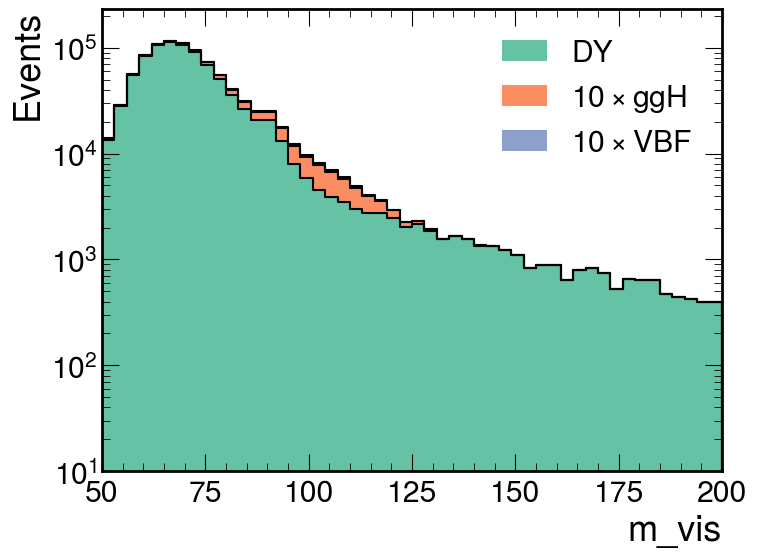

-----------------------------------------
Split Signal Strength Fit Results:
mu_ggH = 1.0 ± 0.4769
mu_VBF = 1.004 ± 4.0981
Precision:
mu_ggH:  47.71%
mu_VBF:  408.19%
-----------------------------------------



In [8]:
variables = "m_vis"
bins = np.linspace(50,200,num=51)
categories = None
precision_mu_split = blf.fit(variables, bins, categories, method="split")

In [9]:
precision_mu = blf.fit(variables, bins, categories, method="inclusive", plot=False) # plot=False as do not need to remake the same plot

-----------------------------------------
Inclusive Signal Strength Fit Results:
mu = 1.0 ± 0.1008
Precision:
mu:  10.08%
-----------------------------------------



The previous example is very basic and you get very poor performance for VBF. If you look closely at the data you will see that VBF is more prominent when n_jets >= 2, jdeta > 2.5 and mjj > 200. Therefore, we define two orthogonal splits of the data (called categories). In each category we fit some bins of the m_vis variable. We have to tune the number of bins for each case, so not to increase the fractional statistical uncertainty in a bin to too large a value. We now see much better results in the split signal strengths.

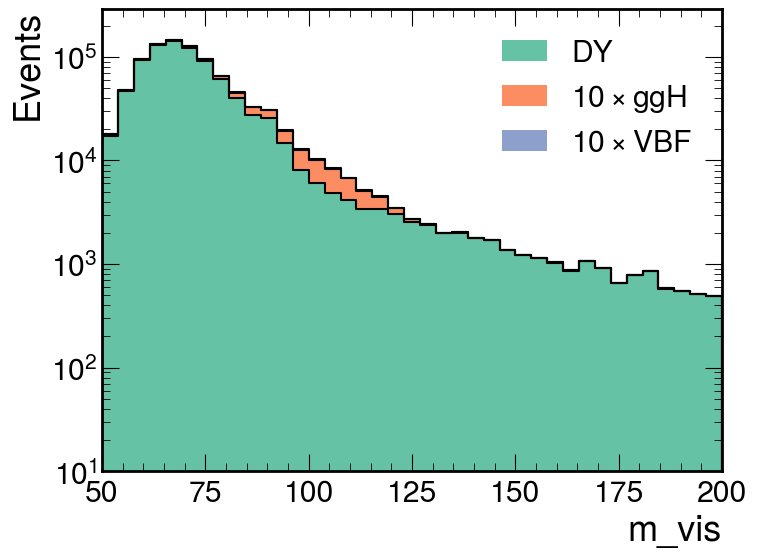

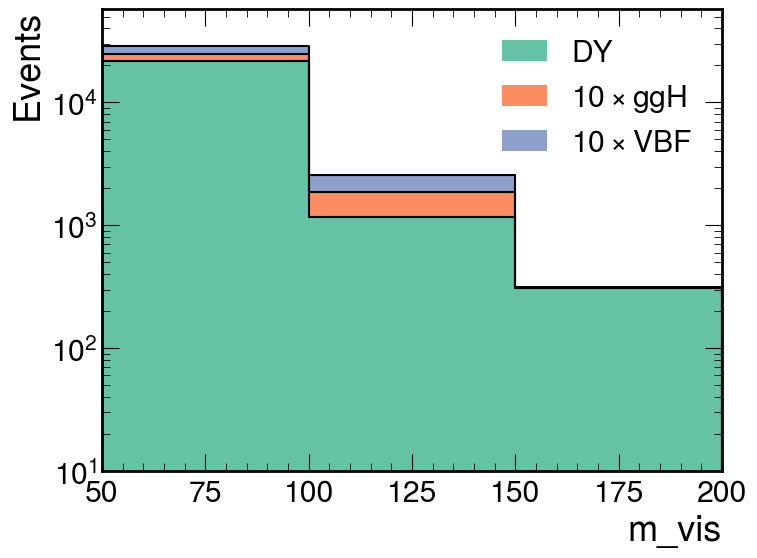

-----------------------------------------
Split Signal Strength Fit Results:
mu_ggH = 1.0 ± 0.1267
mu_VBF = 1.0 ± 0.469
Precision:
mu_ggH:  12.67%
mu_VBF:  46.9%
-----------------------------------------



In [10]:
variables = ["m_vis","m_vis"]
bins = [np.linspace(50,200,num=40), np.linspace(50,200,num=4)]
categories = ["not (n_jets>=2 and jdeta>2.5 & mjj>200)", "(n_jets>=2 and jdeta>2.5 & mjj>200)"]
precision_mu_split = blf.fit(variables, bins, categories, method="split")

In [11]:
precision_mu = blf.fit(variables, bins, categories, method="inclusive", plot=False)

-----------------------------------------
Inclusive Signal Strength Fit Results:
mu = 1.0 ± 0.0997
Precision:
mu:  9.97%
-----------------------------------------



This now does much better for ggH and VBF. The multidimensionality of the dataset is important in optimising the Higgs boson search!

Warnings: Make sure categories are orthogonal (the same event is not in more than one category) and that you do not bin the histograms too finely.

The CMS published analysis managed a statistical precision of:
   * mu_ggH: 9%
   * mu_VBF: 18%
   * mu: 6%

See if you can beat it!

### Your work ###

## Section 1: Data pre-processing
Let us read in all the data:

In [12]:
channels = ["et","mt","tt"]
processes = ["DY","ggH","VBF"]
dataset = {}
for channel in channels:
  dataset[channel] = {}
  for process in processes:
    url = f"https://raw.githubusercontent.com/gputtley/ML-Assessment-3/master/{channel}_{process}.pkl"
    dataset[channel][process] = pd.read_pickle(url)

First, let us concatenate all the processes of a given channel into one dataframe. We tag each of the process types as either being 0 (DY), 1 (VBF), 2 (ggH). This will be useful in our multiclass ML modelling later. We also add in a column to tag what the channels ('tt', 'mt', 'et') are as well.  We also replace all invalid entries of -9999 with the means for that particular column of a given dataset.

In [13]:
channels = ["et", "mt", "tt"]
processes = ["DY", "VBF", 'ggH']

for channel in channels:
    data_choice = dataset[channel].copy()
    data_choice_list = []

    for process in processes:
        process_data = data_choice[process].copy()
        process_data['label'] = process
        data_choice_list.append(process_data)
    
    data_choice_concat = pd.concat(data_choice_list, axis=0)
    
    data_choice_concat['channel'] = channel
    
    data_choice_concat.replace(-9999.000000, np.nan, inplace=True)
    numerical_columns = data_choice_concat.select_dtypes(include=['number']).columns
    data_choice_concat[numerical_columns] = data_choice_concat[numerical_columns].fillna(data_choice_concat[numerical_columns].mean())
    
    data_choice_concat.to_csv(f'data_{channel}.csv', sep=',', index=False, encoding='utf-8')

Having run the above cell once, we can simply read-in the concatenated DataFrames:

In [14]:
data_tt = pd.read_csv('data_tt.csv')
data_et = pd.read_csv('data_et.csv')
data_mt = pd.read_csv('data_mt.csv')

Let us look at these:

In [15]:
display(data_tt)

,dR,dijetpt,dphi,eta_1,eta_2,jdeta,jpt_1,jpt_2,m_vis,met,...,n_jets,pt_1,pt_2,pt_tt,pt_vis,q_1,q_2,svfit_mass,label,channel
0,2.414482,131.900180,2.373276,0.288935,-0.155231,2.831614,42.114372,49.935864,86.581536,30.150600,...,1.0,48.971975,42.047497,56.198355,34.711005,1.0,-1.0,122.340492,DY,tt
1,0.905428,105.572950,-0.870895,-1.301026,-1.053353,0.309145,202.115177,155.836621,47.121035,74.118637,...,3.0,67.624255,42.424370,167.510356,100.343648,-1.0,1.0,81.164604,DY,tt
2,1.786701,131.900180,-1.725332,-1.701998,-1.237745,2.831614,81.649279,49.935864,68.659531,24.880594,...,1.0,43.318895,43.055293,77.721734,56.179411,-1.0,1.0,90.083839,DY,tt
3,3.261100,131.900180,-3.132327,0.415204,-0.492155,2.831614,104.229291,49.935864,272.676875,79.535843,...,0.0,161.267835,94.447914,12.772213,66.829704,1.0,-1.0,394.964371,DY,tt
4,2.808269,44.089320,2.768047,-0.933327,-1.406919,0.360274,51.960214,24.052974,110.202417,13.298456,...,1.0,71.982552,41.230914,23.789963,36.810342,-1.0,1.0,121.641335,DY,tt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100463,2.881543,131.900180,2.704463,-0.042097,0.952473,2.831614,29.491970,49.935864,106.785165,24.866301,...,0.0,54.118938,43.114329,25.319542,23.662201,-1.0,1.0,133.359497,ggH,tt
100464,2.897912,131.900180,2.821907,-0.225061,-0.884404,2.831614,21.338004,49.935864,111.260931,26.148090,...,0.0,55.281822,51.479644,11.302040,17.402144,-1.0,1.0,116.889427,ggH,tt
100465,3.227234,131.900180,3.114076,0.454601,-0.392496,2.831614,38.047721,49.935864,94.207446,34.772629,...,1.0,45.757459,40.713259,30.049737,5.182128,1.0,-1.0,120.592163,ggH,tt
100466,2.615080,131.900180,-2.615061,-0.811133,-0.801338,2.831614,34.070730,49.935864,102.799049,38.338329,...,1.0,62.440515,45.372735,34.122307,32.538654,-1.0,1.0,138.247414,ggH,tt


In [16]:
display(data_et)

,dR,dijetpt,dphi,eta_1,eta_2,jdeta,jpt_1,jpt_2,m_vis,met,...,n_jets,pt_1,pt_2,pt_tt,pt_vis,q_1,q_2,svfit_mass,label,channel
0,3.135951,79.874890,-3.135556,1.555012,1.604772,2.847902,27.200101,37.987213,63.729069,16.207941,...,0.0,31.207733,32.505571,15.074918,1.312003,-1.0,1.0,90.057167,DY,et
1,3.003889,79.874890,2.951380,0.476155,1.035351,2.847902,21.946348,37.987213,71.669383,8.228729,...,0.0,31.439159,38.116100,10.961499,9.370576,1.0,-1.0,96.386219,DY,et
2,2.655823,79.874890,2.493988,-0.813351,0.099567,2.847902,33.851684,37.987213,72.824389,22.239347,...,1.0,28.355934,41.666466,38.342006,25.604705,1.0,-1.0,108.116222,DY,et
3,3.160892,79.874890,-3.060199,0.851678,0.060213,2.847902,30.961701,37.987213,66.871202,12.885175,...,1.0,27.257744,35.246038,17.138495,8.376996,1.0,-1.0,89.943367,DY,et
4,3.133449,50.294590,3.125807,-0.209278,0.009428,0.266964,42.408942,26.465815,69.783803,20.906631,...,1.0,27.302708,44.051275,23.770674,16.757512,-1.0,1.0,103.588017,DY,et
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39752,2.972724,41.099052,-2.945246,1.284314,0.881053,2.765776,28.027470,22.805185,87.100425,28.584808,...,0.0,27.223938,67.522329,31.173893,41.165526,-1.0,1.0,142.703896,ggH,et
39753,1.988086,70.106190,-1.734394,0.540633,1.512416,1.300737,84.842172,24.058138,84.377431,22.850227,...,1.0,31.716288,67.048250,83.697902,69.344806,1.0,-1.0,105.360596,ggH,et
39754,2.321551,60.822487,-2.268782,-0.018115,0.474052,4.002689,60.844223,39.520748,70.414850,30.095181,...,2.0,26.303358,53.359626,71.732262,41.654258,1.0,-1.0,112.564312,ggH,et
39755,3.059016,79.874890,-3.054792,-0.895264,-1.055967,2.847902,62.190320,37.987213,77.002887,26.846807,...,0.0,32.658279,45.166145,15.840545,12.944237,-1.0,1.0,117.176281,ggH,et


In [17]:
display(data_mt)

,dR,dijetpt,dphi,eta_1,eta_2,jdeta,jpt_1,jpt_2,m_vis,met,...,n_jets,pt_1,pt_2,pt_tt,pt_vis,q_1,q_2,svfit_mass,label,channel
0,3.202868,47.860638,-3.083216,0.691623,-0.175638,1.951023,27.347350,23.645488,66.651101,44.631508,...,0.0,25.029474,36.971821,36.436358,12.073620,1.0,-1.0,120.550201,DY,mt
1,3.283137,51.799065,-2.715824,0.322604,2.167404,0.807674,46.037551,30.676097,106.325416,41.355976,...,2.0,40.996746,33.194006,44.663535,17.431898,1.0,-1.0,153.967606,DY,mt
2,3.077966,88.563190,3.049641,-1.894834,-1.478226,2.962839,69.325237,40.530268,77.890553,50.038437,...,0.0,34.568104,42.097557,41.754971,8.305904,1.0,-1.0,121.495884,DY,mt
3,3.589158,88.563190,-3.051042,-0.260118,1.630174,2.962839,69.325237,40.530268,77.096911,32.553864,...,0.0,21.090567,32.152752,21.434276,11.310542,-1.0,1.0,120.229568,DY,mt
4,3.058990,88.563190,-3.052492,-1.569148,-1.768419,2.962839,69.325237,40.530268,62.166178,34.605640,...,0.0,23.811756,40.244199,21.724077,16.662169,1.0,-1.0,107.013268,DY,mt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249923,2.842412,88.563190,-2.817504,0.781560,0.406097,2.962839,24.963781,40.530268,91.352857,6.091706,...,0.0,33.106102,62.414656,29.948629,32.773909,1.0,-1.0,111.303822,ggH,mt
249924,3.205294,6.816928,-2.948747,1.337029,0.080526,0.898123,31.929883,25.970035,86.717515,23.089787,...,1.0,26.750084,48.786219,2.171294,23.107891,1.0,-1.0,125.594868,ggH,mt
249925,3.205428,88.563190,3.096526,0.119235,-0.709193,2.962839,27.258947,40.530268,76.788181,36.957520,...,0.0,28.121450,44.368664,21.826239,16.325000,-1.0,1.0,125.825127,ggH,mt
249926,2.827211,29.214500,-2.811898,0.181217,-0.112640,3.725041,33.129554,24.281065,75.576269,16.293961,...,1.0,43.016068,33.361486,2.279725,15.741467,-1.0,1.0,99.166138,ggH,mt


We note here that the discrepancies in the number of columns is due to the fact that `mva_dm_1` is only available for the `tt` channel. 

Let us combine these three dataframes:

In [20]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# First concatenate all data into one dataframe
# Drop channels, to reduce number of features
data_list = [data_tt.drop(columns = ['channel']), 
             data_mt.drop(columns = ['channel']),
             data_et.drop(columns = ['channel'])]
overall_data = pd.concat(data_list, axis=0)
overall_data.to_csv('overall_data.csv', sep = ',', index = False, encoding = 'utf-8')
# print('Overall data:')
# display(overall_data)

# Next process it - OHC and label marking: DY (0), VBF (1), and ggH (2)
data = overall_data.copy()
numerical_columns = [col for col in data.columns if col not in ['label']]
target_column = 'label'
label_encoder = LabelEncoder()
data['label_encoded'] = label_encoder.fit_transform(data[target_column])

# Now extract the predictors and targets, and save locally
X = data[numerical_columns].copy()
X.fillna(0, inplace = True)
# print('Predictors:')
# display(X)
X.to_csv(f'predictors.csv', sep = ',', index = False, encoding = 'utf-8')
y = data['label_encoded']
# print('Targets:')
# display(y)
y.to_csv(f'targets.csv', sep = ',', index = False, encoding = 'utf-8')
print('Check counts per process:')
display(overall_data['label'].value_counts())

Check counts per process:


label
ggH    193458
DY     111380
VBF     85315
Name: count, dtype: int64

Looking at the counts per process, there are noticable imbalances in our classes: the counts for VBF is less than half of ggH, while those for DY are a bit less than half of ggH. Going forward, we need to bear this in mind.

## Section 2: Multiclass Implementation using Recursive Feature Elimination (RFE)
Let us load in some of the other ML libraries and modules that we will be using in our analysis:

In [36]:
# Can ignore the warning that shows up
from sklearn.feature_selection import RFECV
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import json
from scipy.stats import randint, uniform
import matplotlib.pyplot as plt
import pandas as pd
import xgboost as xgb
import joblib
import pickle
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA
import optuna
optuna.logging.set_verbosity(optuna.logging.CRITICAL)
from sklearn.metrics import f1_score

We will leverage XGBoost's `XGBClassifier()` for multiclass classification of particle decay processes (DY - 0, VBF - 1, ggH - 2). The target variable corresponds to the previously defined process labels (0 for 'DY', 1 for 'VBF', and 2 for 'ggH'), and the predictors will include the remaining columns in the dataset. The end goal will be to predict the probabilities of each entry belonging to the three classes. The outputs here should be of the form: `[p(Class-DY), p(Class-VBF), p(Class-ggH)]` for each entry in the dataframe.

### 2.1 Work plan

Let us make an outline of our analysis:

#### **Goals**

- *Feature Reduction*: Identify a minimal subset of features that maximally contribute to distinguishing between the three classes. This will simplify the model and enhance interpretability of decision rules that can confidently idenitify each class.
- *Model Optimization*: Fine-tune the hyperparameters of the XGBoost model to ensure optimal performance while maintaining interpretability.
- *Probability Predcition*: Fit the trained model to the overall dataset and predict, for each entry in the dataset, the probability of belonging to each of the three classes.
- *Decision Boundaries*: Use the selected features and probabilities to determine clear numerical decision boundaries for classification.

#### **Methodology**


- *Class Imbalance Handling*:
    - Use the **f1_weighted** scoring metric during evaluation to account for imbalanced class distributions.
    - Use **stratified sampling** to preserve fractions of target classes from original dataset in training and testing sets.

- *Feature Selection*:
    - Perform **recursive feature elimination with cross-validation (RFECV)** using sklearn's `RFECV()` class to identify the most important features. This step will be encapsulated in a function, `rfecv_multi()`, which will return a reduced set of features.
- *Hyperparameter Tuning*:
    - Conduct **hyperparameter optimisation** on the reduced dataset using `Optuna` to determine the best model parameters.
    - This will be done using a function `multiclassification()`, which will have two 'modes', as detailed below. This will have two possible outputs:
        1) The tuned model, along with (a fixed number of) the top features, and the hyperparameters obtained from model tuning.
        2) The predicted probabilities of each entry in the dataset belonging to each class.
#### **Evaluation**

- Generate and inspect the confusion matrix to assess classification accuracy and errors.
- Report detailed classification metrics, such as, per-class f1-scores.
- Visualize feature importance for the selected features.

#### **Workflow**

- Perform feature selection using RFECV:
  
    - Use `rfecv_multi()` to identify the most important features, ensuring that irrelevant features are removed, simplifying the model.

- Train and test the model on the reduced dataset:
  
  - Pass the selected features and the reduced dataset to a second function, `multiclassification()`, for training and evaluation.
  - Incorporate hyperparameter tuning using `Optuna` to optimize performance.
  
- Lastly, use the trained model on the entire dataset to predict the probabilities, for each entry in our dataset, of belonging to a given class. This is the main output of our model.

Now, we write two key functions:

- Feature Selection Function: `rfecv_multi()`, to perform RFECV.
- Model Training Function: `multiclassification()` to train and evaluate the XGBoost model on the reduced feature set, incorporating hyperparameter tuning. This function will have two modes: one to perform hyperparameter tuning and top-feature extraction, and the other to calculate the probabilities of belonging to each class.

### 2.2 Helper funtions
Let us define some helper functions to aid in our analysis going forward:

In [1]:
def evaluation(y_true, y_pred):
    """ 
    Helper function to evaluate and display model metrics. 

    Parameters:
    - y_true : True values of the target variable(s) (list or array-like).
    - y_pred : Model predictions of target variable(s) (list or array-like).

    Outputs:
    - Classification report for predictions against true values. For each class, includes:
        -> Precision
        -> Recall
        -> F1 Score
        -> Accuracy
    - Macro and Weighted averages of each of the above metrics.
    - Confusion matrix for classifcations vs true values of each class.
    """
    
    print(f"\nFinal Classification Report:\n")
    print(classification_report(y_true, y_pred))
    
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()

def feature_importance(features, feature_importances):
    """ 
    Helper function to plot feature importance.
    
    Parameters:
    - features: List or array-like object of features whose importances are to be visualised.
    - feature_importance: List or array-like object of feature importance scores for above features.

    Output:
    - Bar plot of features and feature importance scores.
    """
    assert len(features) == len(feature_importances), 'Need equal numbers of features and importances'
    feature_importance_df = pd.DataFrame({
        'Feature': features,
        'Importance': feature_importances})

    print(f"\nFeature importance (selected features):")
    print(feature_importance_df)

    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.title('Feature Importance (Selected Features)')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

def saver(save = 'both', model = None, features = None, 
          model_filename='best_model.pkl', features_filename='selected_features.pkl'):
    """ 
    Helper function to locally save the best model and/or selected features
    from the feature selection step.

    Parameters:
    - save : Save 'both' model and features, only 'model', or only 'features'.
    - model : Model object to save.
    - features : List or array-like object of features to save.
    - model_filename : Specify name of saved model file.
    - features : Specify name of saved features file.
    """
    
    if save not in ['both', 'model', 'features']:
        raise ValueError("Invalid value for 'save'. Choose from 'both', 'model', or 'features'.")

    if save == 'both':
        if model is None or features is None:
            raise ValueError('Need to specify both model and features to save!')
        else:
            joblib.dump(model, model_filename)
            print(f"Model saved to {model_filename}")
        
            with open(features_filename, 'wb') as f:
                pickle.dump(features, f)
            print(f"Features saved to {features_filename}")
        
    elif save == 'model':
        if model is None:
            raise ValueError('Need to specify model to save!')
        else:
            joblib.dump(model, model_filename)
            print(f"Model saved to {model_filename}")

    elif save == 'features':
        if features is None:
            raise ValueError('Need to specify features to save!')
        else:
            with open(features_filename, 'wb') as f:
                pickle.dump(features, f)
            print(f"Features saved to {features_filename}")

def loader(load = 'both', 
           model_filename='best_model.pkl', features_filename='selected_features.pkl'):
    """ 
    Helper function to read-in the best model and/or selected features
    from the feature selection step. Intended to pass these into the hyper-
    parameter optimisation step.

    Parameters:
    - load : Load 'both' model and features, only 'model', or only 'features'.
    - model_filename : Specify name of model file to load.
    - features : Specify name of features file to load.
    """

    if load not in ['both', 'model', 'features']:
        raise ValueError("Invalid value for 'load'. Choose from 'both', 'model', or 'features'.")
        
    if load == 'both':
        
        model = joblib.load(model_filename)
        print(f"Model loaded from {model_filename}")
        
        with open(features_filename, 'rb') as f:
            features = pickle.load(f)
        print(f"Features loaded from {features_filename}")
        
        return model, features
        
    elif load == 'model':
        
        model = joblib.load(model_filename)
        print(f"Model loaded from {model_filename}")
        
        return model
        
    elif load == 'features':
        
        with open(features_filename, 'rb') as f:
            features = pickle.load(f)
        print(f"Features loaded from {features_filename}")
        
        return features

### 2.3 Main Functions

Let us now define the functions that will do the heavy-lifting in our analysis:

In [24]:
def rfecv_multi(X, y, model = None, min_features = 10, verbosity = True, plot = True):
    """
    Perform feature selection using Recursive Feature Elimination with Cross-Validation (RFECV)
    and an XGBoost classifier. Intended to be used first, *before* 'multiclassification()' function.

    Parameters:
    - X: Features (array-like or dataframe).
    - y: Target Labels (array-like).
    - model: XGBClassifier() (can be pre-trained or new; specify 'model' parameter as your pre-trained model).
    - min_features: Minimum number of features to be left in *after* rfecv.
                    *Not* a condition on rfecv; can return more than this number.
    - verbosity: whether or not the total number of selected features, along with the features themselves,
                 are displayed.

    Outputs:
    - Sorted list/array-like object of features selected using RFECV.
    - Ranked features by feature importance and bar chart for comparison.
    """

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify=y)
    if model is None:
        print('Initialising new model...')

        # Ensure model can handle multiclass problem
        model = xgb.XGBClassifier(
            eval_metric = 'mlogloss',
            objective = 'multi:softprob',
            num_class = len(np.unique(y)),
            n_jobs = -1
        )
    else:
        print('Proceeding with pre-trained model...')

    # Need to handle class imbalances
    skf = StratifiedKFold(n_splits = 3, shuffle = True)

    rfecv = RFECV(estimator = model,
                  step = 1,
                  cv = skf,
                  scoring = 'f1_weighted', # Safe for multiclass
                  min_features_to_select = min_features,
                  verbose = 0, # Avoiding too much info
                  n_jobs = -1
                 )

    print("Fitting RFECV to the data...")
    rfecv.fit(X_train, y_train)

    # Return list of selected features, ranked 1 (highest) by rfecv
    # Appears in the same order as in X
    selected_features = X.columns[rfecv.support_].tolist()
    
    # Get corresponding feature importances
    importances = rfecv.estimator_.feature_importances_

    # Make into sorted list-like object; ranked by feature importance
    sorted_features = sorted(zip(selected_features, importances), key=lambda x: x[1], reverse=True)
    
    # Selected features sorted by importance
    top_features = [f[0] for f in sorted_features]
    
    # *ONLY FOR PLOTTING*
    top_features_min = [f[0] for f in sorted_features[: min_features]]
    top_importances = [f[1] for f in sorted_features[: min_features]]

    if verbosity:
        print(f"\nTotal: {len(top_features)} features selected (sorted by importance):")
        print(f"{top_features}\n")

    # Visualise feature importance of top performing features
    if plot:
        feature_importance(top_features_min, top_importances)
    
    return top_features

Here, we implement a more advanced hyperparameter tuning algorithm using `Optuna`, a framework based on Bayesian optimisation. Unlike traditional methods such as `GridSearchCV()` or `RandomizedSearchCV()`, which search through hyperparameter spaces exhaustively or randomly, `Optuna` efficiently explores the search space by selecting the most promising hyperparameters based on past trial results. 

Though this may not be necessary in our case, an implementation like this would generalise well to larger, more complex datasets. 

We first need to define an `objective()` function that will be passed in when create a 'study' using Optuna (more on this below):

In [27]:
def objective(trial, X_train, y_train):
    """
    Objective function for Optuna's optimisation using XGBoost. It receives a trial 
    and returns a score for the hyperparameters suggested by Optuna. 
    This function defines the search space for hyperparameters and evaluates 
    their performance using StratifiedKFold cross-validation and the (weighted) F1 score.

    Parameters:
    - trial: optuna.trial object, suggests hyperparameters for optimisation
    - X_train: training feature set (dataframe)
    - y_train: training target set (array-like)
    """
    param = {
        'eval_metric': 'mlogloss',
        'objective': 'multi:softprob',
        'num_class': len(np.unique(y_train)),
        'n_jobs': -1,
        'n_estimators': trial.suggest_int('n_estimators', 200, 2000),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'max_leaves': trial.suggest_int('max_leaves', 2, 11),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 10.0),
        'gamma': trial.suggest_float('gamma', 0.0, 5.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'max_delta_step': trial.suggest_int('max_delta_step', 0, 10)
    }

    # Initialize model with parameters from trial
    model = xgb.XGBClassifier(**param)

    # Initialize cross-validation
    skf = StratifiedKFold(n_splits=3, shuffle=True)
    scores = []

    # Easier to work with arrays here
    X_train = X_train.to_numpy()
    y_train = y_train.to_numpy()
    for train_idx, val_idx in skf.split(X_train, y_train):
        
        # Split data according to cross-validation indices
        X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
        y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]
        
        # Train and evaluate on fold
        model.fit(X_fold_train, y_fold_train)
        y_pred = model.predict(X_fold_val)
        
        # Compute F1 score (weighted average for multiclass)
        score = f1_score(y_fold_val, y_pred, average='weighted')
        scores.append(score)

    # Return the mean of the F1 scores
    return np.mean(scores)

In [2]:
def multiclassification(X, y, model=None, selected_features=None, 
                        prob=False, tune = True, n_iter=25, 
                        max_features=10, stats=True):

    """
    Double-mode function, intended to be used *after* a reduced feature set is obtained from 'rfecv_multi()'.
    
    If prob == False:
        -> Perform multiclass classification (optionally tune hyperparameters using Optuna) 
           and evaluate using XGBClassifier(). Identifies a *fixed number* of top features based on feature importance.
        
    elif prob == True:
        -> Predict the probabilities of each entry in the data of belonging to each of the target classes.
        
    Parameters:
    - X: Features (dataframe).
    - y: Target Labels (array).
    - model: XGBClassifier() (can be pre-trained or new; specify 'model' parameter as pre-trained model).
    - selected_features: Features (intended to be from RFECV) to be retained in X, (list or array-like).
    - prob:
        - False: Hyperparameter tuning and performance evaluation.
        - True: Calculate probabilities of belonging to each class.

    If prob == False, (optionally) specify the following:
        - tune: Hyperparameter distributions for model tuning. 'False' skips this.
        - n_iter: Number of trials used by Optuna (default = 25).
        - max_features: Number of top features to select based on importance (default = 10).
        - stats: whether or not detailed statistics are included in the output.

    Outputs:
    - If prob ==  False:
        -> Hyperparameter-tuned model, a fixed set of top-features determined via
           feature importance ranking, and the best params found from tuning procedure.
    - If prob == True:
        -> Probabilities of each data point belonging to each of the target classes.
        
    """
     
    # Some checks to ensure that the intended previous steps were completed
    if prob:
        if selected_features is None:
            raise ValueError("Parameter: selected_features must be provided when prob = True.")
        if model is None:
            raise ValueError("Parameter: model must be provided when prob = True.")
        best_model = model
        best_model.fit(X[selected_features], y)
        y_proba = best_model.predict_proba(X[selected_features])
        return y_proba

    else:
        if model is None:
            print('Initialising new model...')
            model = xgb.XGBClassifier(
                eval_metric='mlogloss',
                objective='multi:softprob',  # Useful when calculating class probabilities
                num_class=len(np.unique(y)),
                n_jobs=-1
            )
        else:
            print('Proceeding with pre-trained model...')

        if selected_features is None:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)
            print('No features specified. Using all features in X.')
        else:
            X_train, X_test, y_train, y_test = train_test_split(X[selected_features], y, test_size=0.25, stratify=y)
            print('Filtered X by selected features.')
            
        # Use Optuna for hyperparameter tuning
        if tune:
            print('Initiating hyperparameter tuning...')
            study = optuna.create_study(direction='maximize')
            study.optimize(lambda trial: objective(trial, X_train, y_train), 
                           n_trials=n_iter, n_jobs = -1)
            best_params = study.best_params
            print(f"\nBest parameters from Optuna: {best_params}")
        else:
            print('Skipping hyperparameter tuning...')
            best_params = model.get_params()

        # Train model with best parameters found by Optuna (or not)
        best_model = xgb.XGBClassifier(**best_params)
        best_model.fit(X_train, y_train)

        booster = best_model.get_booster()
        feature_scores = booster.get_score(importance_type='gain')

        if not feature_scores:
            raise ValueError("No feature scores found. Ensure model is trained correctly.")

        feature_importance_df = pd.DataFrame(sorted(feature_scores.items(), key=lambda x: x[1], reverse=True),
                                             columns=['Feature', 'Importance'])

        top_features = feature_importance_df['Feature'][:max_features]
        top_importances = feature_importance_df['Importance'][:max_features]

        # This bit seems redunant, but is useful if we 
        # want an even smaller feature set to be used in evaluation
        X_train_selected = X_train[top_features]
        X_test_selected = X_test[top_features]

        best_model.fit(X_train_selected, y_train)
        
        y_pred = best_model.predict(X_test_selected)
        
        if stats:
            evaluation(y_test, y_pred)
            feature_importance(top_features, top_importances)

        return best_model, top_features, best_params

The above functions may seem quite extensive, but we have included doc strings, comments and print statements to ensure that they can be run smoothly.

## Section 3: Initial Runs, Model Tuning, and Class Probabilities

### 3.1a Performing RFECV on dataset

Let us begin by performing RFECV on our dataset to filter out the least important features, leaving only the most important ones.

Initialising new model...
Fitting RFECV to the data...

Total: 19 features selected (sorted by importance):
['n_jets', 'mjj', 'svfit_mass', 'm_vis', 'dR', 'pt_vis', 'jpt_1', 'jdeta', 'mva_dm_1', 'jpt_2', 'mva_dm_2', 'pt_2', 'dijetpt', 'mt_lep', 'pt_tt', 'mt_tot', 'pt_1', 'dphi', 'met_dphi_2']


Feature importance (selected features):
      Feature  Importance
0      n_jets    0.311270
1         mjj    0.166955
2  svfit_mass    0.115114
3       m_vis    0.098079
4          dR    0.049316
5      pt_vis    0.048581
6       jpt_1    0.046682
7       jdeta    0.032333


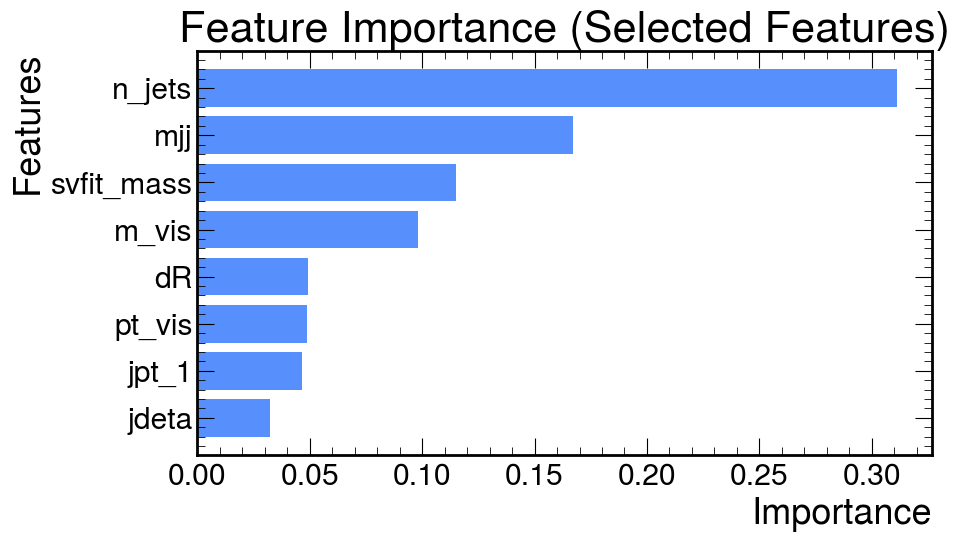

Features saved to features_rfecv.pkl


In [29]:
# Syntax: feature_selection_rfecv_multi(X, y, model = None, min_features = 10, stats = True)
X = pd.read_csv("predictors.csv")
y = pd.read_csv("targets.csv")
overall_data = pd.read_csv("overall_data.csv")
selected_features = rfecv_multi(X, y, min_features = 8)
saver(save = 'features', features = selected_features,  features_filename = 'features_rfecv.pkl')

We have now reduced the feature set, though not to a large extent. RFECV thinks that all of these features are equally important, since the `.support_` method returns the most important features (i.e. the selected features). Internally, RFECV will produce a ranking of features, and it assigns lower numbers to more importance features; 1 is assigned to the most important feature(s), which are the **selected features**. 

If we want to obtain a minimal set of features that maximally distinguish between classes, we might need to pick out the top performing features from now. 

We note here that using `RFE()` from `sklearn` would ensure that only a specified minimum number of features are chosen, but the caveat is that this skips cross-validation. There is a trade-off in terms of features retained, but our method ensures that the best performing set of features are returned, determined through cross-validation. This will not be guaranteed by `RFE()`.

We can check if the features above and their ranking correspond to the the feature importances returned by an `XGBClassifier()` itself, when training on the entire dataset, as well as, the dataset filtered using the selected features. 

We can return feature importances according to the 'gain' metric, which measures how much a given feature improves a model's predictive power when used in a split. This is particularly useful to us, since we are interested in the features that can best discriminate between classes.

### 3.1b Train-Test-Validate on entire dataset with vanilla `XGBClassifier()`

Let us consider fitting a vanilla model onto the total dataset, to see how well this performs. We will be interested in performance metrics and features ranked by importance.

Initialising new model...
No features specified. Using all features in X.
Skipping hyperparameter tuning...

Final Classification Report:

              precision    recall  f1-score   support

           0       0.71      0.71      0.71     27845
           1       0.76      0.60      0.67     21329
           2       0.72      0.78      0.75     48365

    accuracy                           0.72     97539
   macro avg       0.73      0.70      0.71     97539
weighted avg       0.72      0.72      0.72     97539


Feature importance (selected features):
       Feature  Importance
0       n_jets  221.409210
1          mjj  117.330307
2   svfit_mass   81.197754
3        m_vis   65.788132
4           dR   34.505676
5        jpt_1   32.806332
6       pt_vis   29.143787
7     mva_dm_1   18.713755
8        jdeta   18.684376
9        jpt_2   11.842366
10    mva_dm_2    9.289769
11        pt_2    7.832882
12      mt_lep    7.568807
13       pt_tt    7.280757
14     dijetpt    6.845286


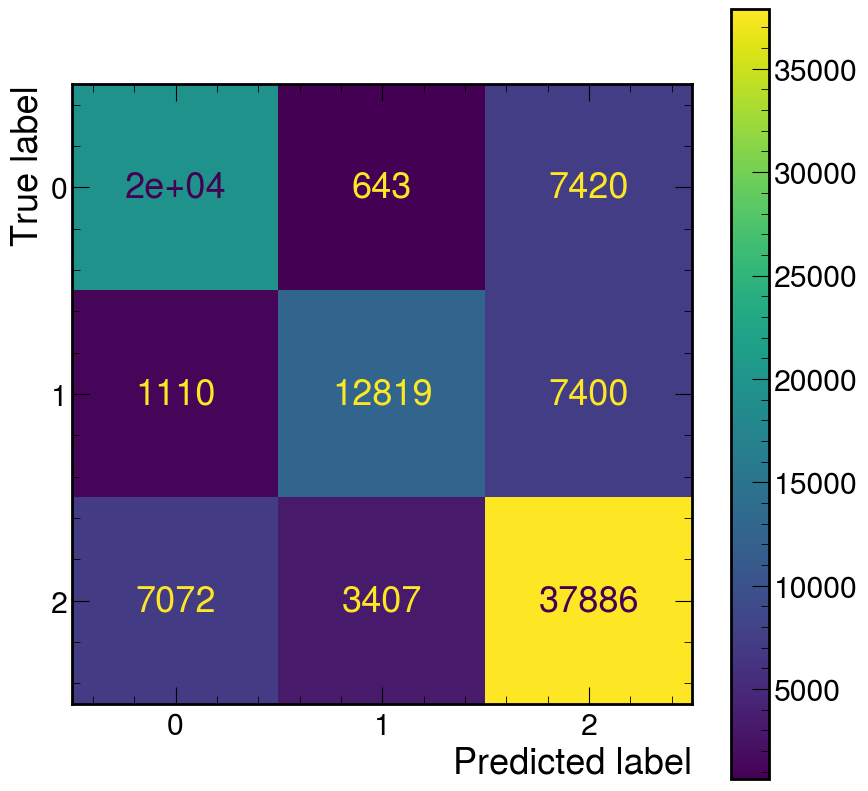

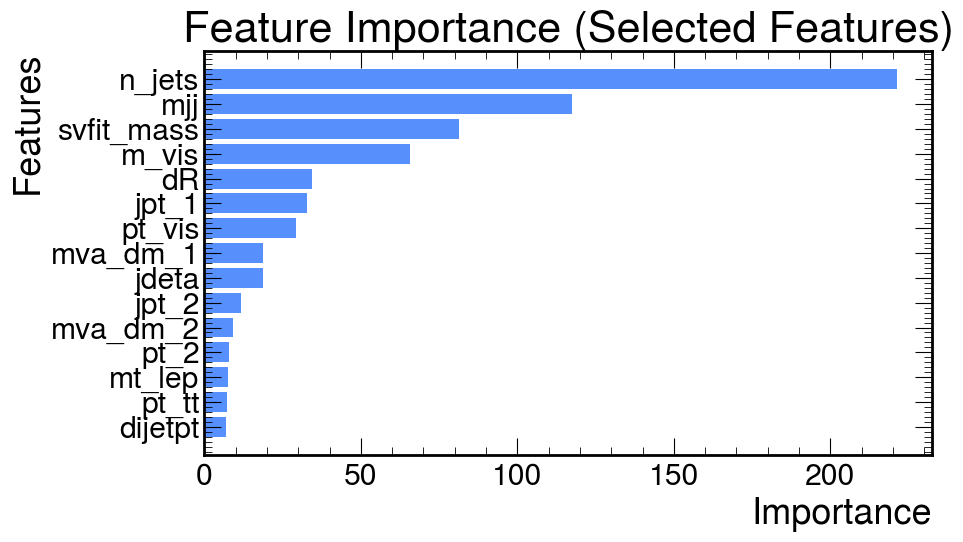

In [31]:
best_model_31b, top_features_31b, best_params_31b = multiclassification(X, y, model = None, selected_features = None, 
                                                                        prob = False, tune = False,
                                                                        max_features = 15)

We find that, at least for the first few, most important, features from each run, there is much overlap between the features determined by RFECV and those given by training and testing a vanilla `XGBClassifier()` on to the entire dataset. We obviously expect the ranking from this last run to vary to some extent, due to the inherent nature of tree-based models.

Note that the two procedures return importance scores with different scalings, but the rankings only depend on the relative importances of the features within each run.

We can expect this agreement to break down as we progress further down the list (in fact, it usually does). Nevertheless, this gives us a good indication that we are on the right track to identifying the features that best differentiate our classes.

### 3.1c Train-Test-Validate on reduced dataset with vanilla `XGBClassifier()`

Let us further consider training a vanilla  model on the dataset after filtering it by the features returned by RFECV:

Features loaded from features_rfecv.pkl
Initialising new model...
Filtered X by selected features.
Skipping hyperparameter tuning...

Final Classification Report:

              precision    recall  f1-score   support

           0       0.71      0.71      0.71     27845
           1       0.76      0.60      0.67     21329
           2       0.72      0.79      0.75     48365

    accuracy                           0.72     97539
   macro avg       0.73      0.70      0.71     97539
weighted avg       0.73      0.72      0.72     97539


Feature importance (selected features):
       Feature  Importance
0       n_jets  194.054169
1          mjj   93.230644
2   svfit_mass   67.084396
3        m_vis   57.186348
4           dR   29.825356
5        jpt_1   26.539799
6       pt_vis   24.906389
7        jdeta   18.144728
8     mva_dm_1   14.437149
9        jpt_2    9.781502
10    mva_dm_2    7.423500
11        pt_2    6.651287
12      mt_lep    6.289629
13        pt_1    5.698225
14     di

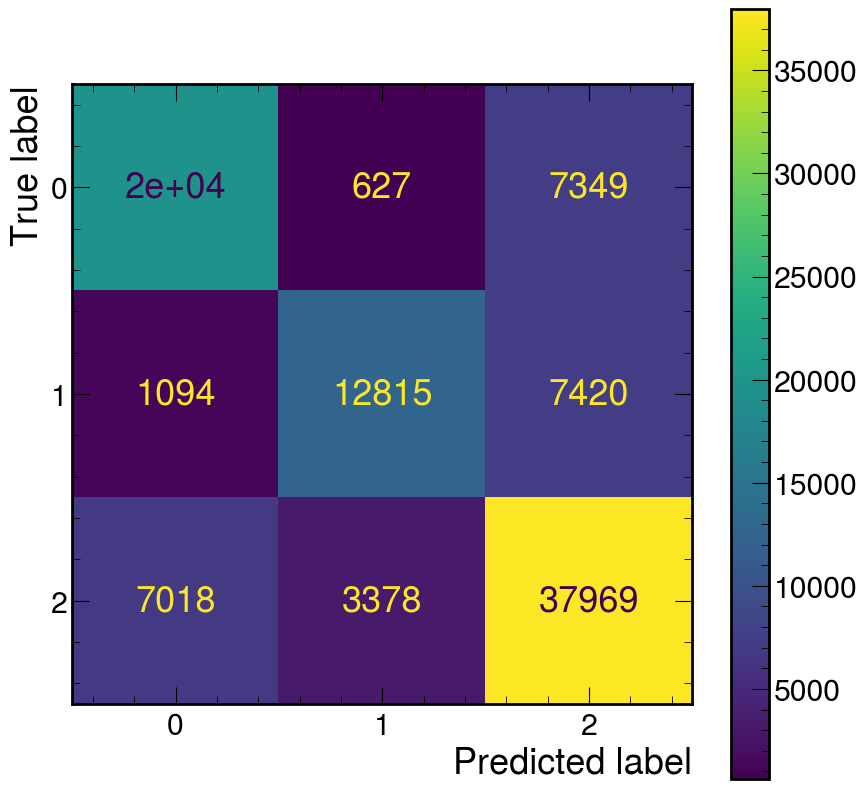

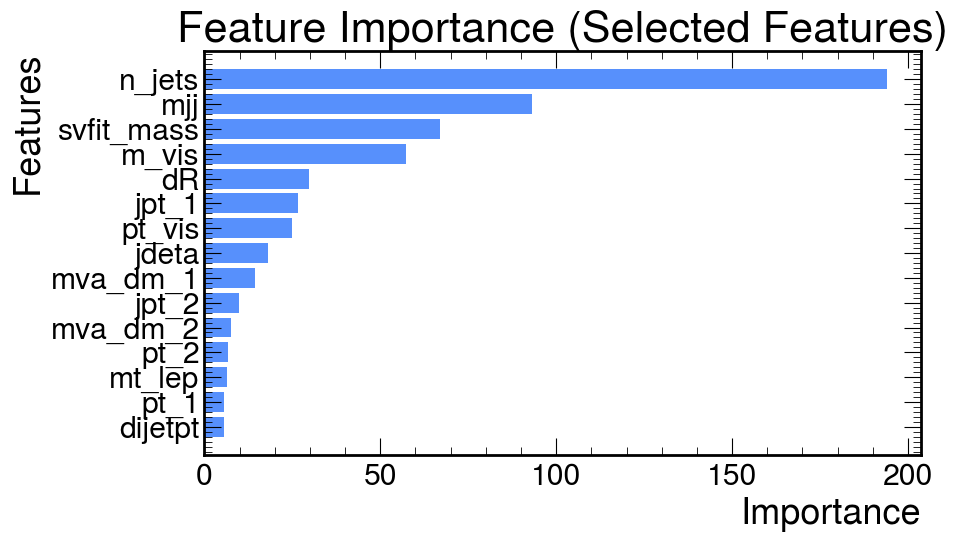

In [33]:
selected_features = loader(load = 'features', features_filename = 'features_rfecv.pkl')
best_model_31c, top_features_31c, best_params_31c = multiclassification(X, y, selected_features = selected_features,
                                                                        tune = False, max_features = 15)

Comparing this last run to the ones above, we again find excellent agreement in terms of the features and their rankings for the highest-ranked features (around 5/6) with both of the above runs. 

When comparing this with the run performed on the entire dataset in 3.1b, we find comparable performance and rankings that agree for the most part all the way down the list, with minor exchanges of features at some points in the list. These may be due to the slight differences caused by to the random nature of our model. Additionally, a feature that may not have played a significant role in guiding the model to make its predictions may become more imoortant on a filtered dataset, where some features have been dropped. However, we find:

**This analysis lends credence to the idea that downsizing our dataset has not negatively affected the predictive capabilities of our model.**

In fact, since we have benchmark metrics, we can consider what happens if we select only some features chosen from RFECV.

Features loaded from features_rfecv.pkl
Initialising new model...
Filtered X by selected features.
Skipping hyperparameter tuning...

Final Classification Report:

              precision    recall  f1-score   support

           0       0.70      0.71      0.70     27845
           1       0.76      0.60      0.67     21329
           2       0.72      0.78      0.75     48365

    accuracy                           0.72     97539
   macro avg       0.72      0.70      0.71     97539
weighted avg       0.72      0.72      0.72     97539


Feature importance (selected features):
      Feature  Importance
0      n_jets  119.583519
1         mjj   56.722939
2  svfit_mass   40.991905
3       m_vis   33.196388
4          dR   17.359163
5       jpt_1   16.025990
6      pt_vis   14.946604
7       jdeta   11.380168
8    mva_dm_1   10.875166
9       jpt_2    6.803110


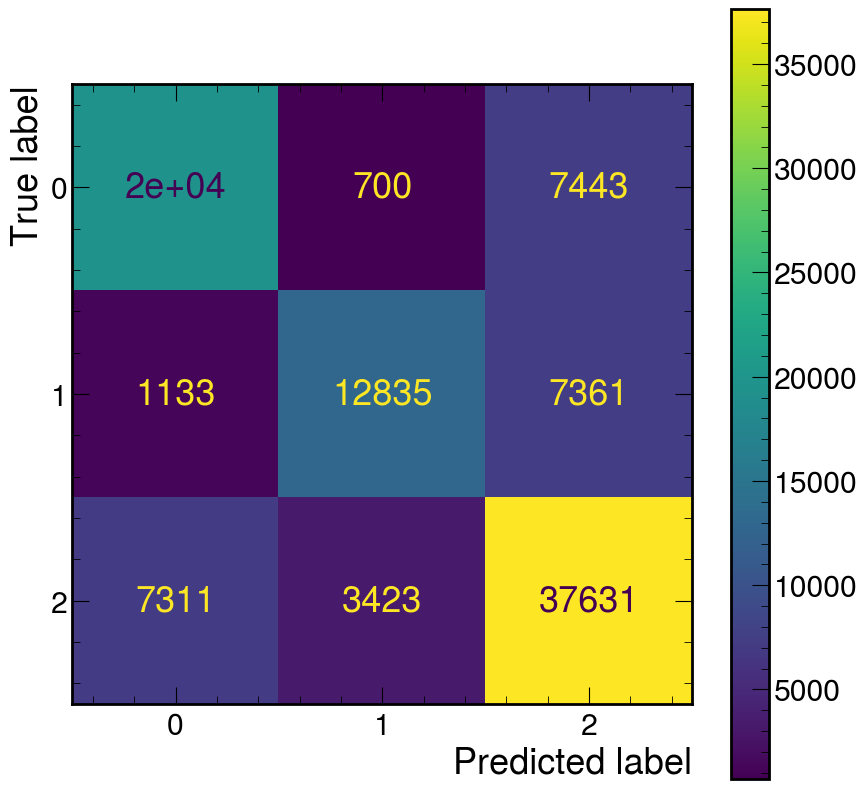

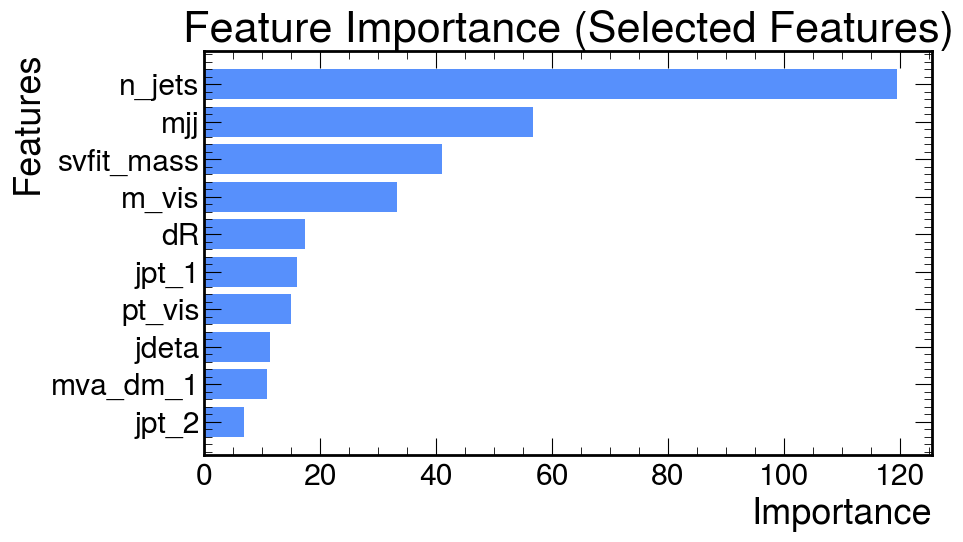

In [35]:
selected_features = loader(load = 'features', features_filename = 'features_rfecv.pkl')
best_model_31d, top_features_31d, best_params_31d = multiclassification(X, y, selected_features = selected_features[:10],
                                                                        tune = False, max_features = 15)

Here, through a bit of trial-and-error, we find that even taking the top 10 features only is enough to allow an untuned model to make predictions comparable to when it was trained on the entire dataset. With this downsized dataset, hyperparameter tuning will also take less time and be less computationally expensive. We focus on this now.

### 3.2 Hyperparameter tuning
Going forward, let us only take these 10 features and fine tune the performance of our model. We expect that the particular hyperparameters might play a role in determining the specificity of the boundaries in the feature space that enable the classes to be separated.

Collapsing the output from the cell below or scrolling all the way to the bottom of the ouput is advisable; Optuna seems to return the results for all iterations and controlling the verbosity is a bit tricky.

Features loaded from features_rfecv.pkl
Initialising new model...
Filtered X by selected features.
Initiating hyperparameter tuning...

Best parameters from Optuna: {'n_estimators': 544, 'max_depth': 3, 'max_leaves': 7, 'learning_rate': 0.280351222641693, 'subsample': 0.578226693468489, 'colsample_bytree': 0.9709442058573963, 'reg_alpha': 2.8053507611611286, 'reg_lambda': 8.338903777669222, 'gamma': 1.062177293319508, 'min_child_weight': 2, 'max_delta_step': 0}

Final Classification Report:

              precision    recall  f1-score   support

           0       0.71      0.71      0.71     27845
           1       0.75      0.60      0.67     21329
           2       0.72      0.78      0.75     48365

    accuracy                           0.72     97539
   macro avg       0.72      0.70      0.71     97539
weighted avg       0.72      0.72      0.72     97539


Feature importance (selected features):
      Feature  Importance
0      n_jets  120.797203
1         mjj   51.231781
2  

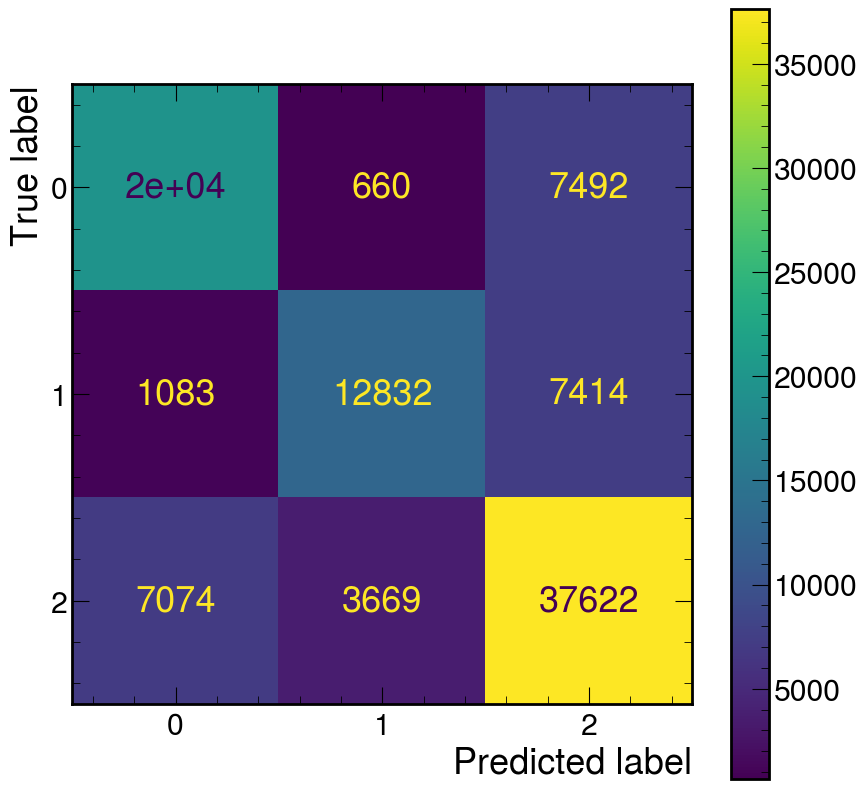

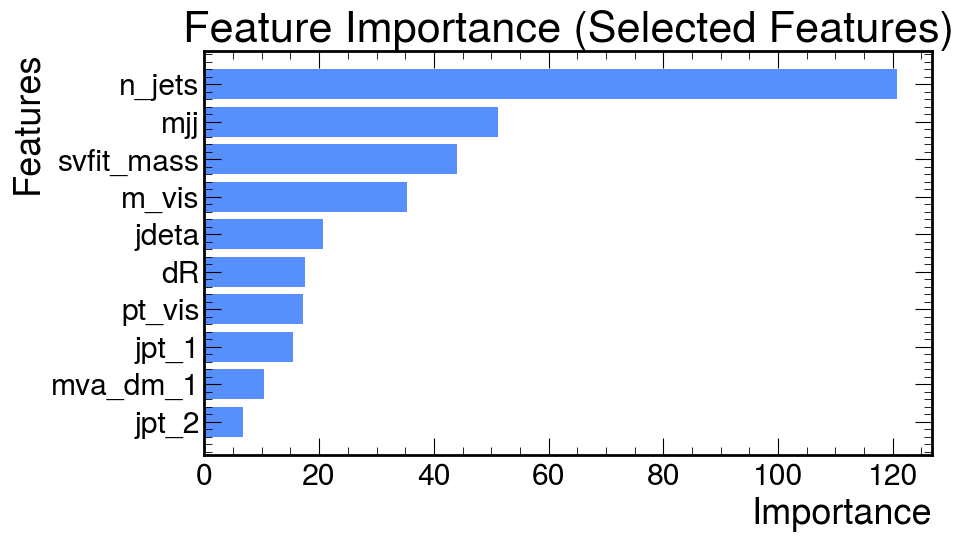

Model saved to model_multi.pkl
Features saved to features_multi.pkl


In [37]:
# Syntax: multiclassification(X, y, model = None, selected_features = None,  
#                             prob = False, param_dists = None, 
#                             n_iter=25, max_features=10, stats = True)
selected_features = loader(load = 'features', features_filename = 'features_rfecv.pkl')
selected_features = selected_features[:10]
best_model_, top_features, best_params = multiclassification(X, y, selected_features = selected_features, 
                                                             tune = True, n_iter = 20,
                                                             max_features = len(selected_features))
saver(save = 'both', 
      model = best_model_, features = top_features, 
      model_filename = 'model_multi.pkl', features_filename = 'features_multi.pkl')

At the end, we want to be able to use suitable outputs from our ML model that can advise our choice of variables and categories when using the `.fit()` method of the `BinnedLikelihoodFit` class from before. One set of suitable outputs are the probabilities that the model assigns each event of belonging to one of the three classes. This can help us discern, for e.g., the regions of our feature space that our classifier thinks is 'characteristic' for a given class, and also the regions about which our model is not so sure.

For example, say the model assigns the following probabilities to an arbitrary event from our dataset: `[0.8, 0.08, 0.12]`, meaning that it predicts that the event belongs to Class 0 (DY) with proability 0.8, belongs to Class 1 (VBF) with probability 0.08 and that it belongs to Class 2 (ggH) with probability 0.12. 

When making predictions, and given our configuration, the model will internally assign whatever class has the highest probability as the predicted class for that data point. Obviously, the model can be wrong in this prediction, but for our purposes this is not an issue, since we are interested in the most-discerning features for our dataset, and not model performance/generalisability.

We will discuss more about this idea and how it relates to our task in Section-4. For now, however, we train and test the model on the entire dataset to obtain the probabilities of belonging to each class (i.e. the **class probabilities**).

In [38]:
best_model_multi, selected_features_multi = loader(load = 'both', 
                                                   model_filename = 'model_multi.pkl', 
                                                   features_filename = 'features_multi.pkl')
print(selected_features_multi)
probs = multiclassification(X, y, best_model_multi, selected_features_multi, prob = True)
overall_data_multi = overall_data.copy()
overall_data_multi['labels_encoded'] = y
overall_data_multi['prob_0'] = probs[:, 0]
overall_data_multi['prob_1'] = probs[:, 1]
overall_data_multi['prob_2'] = probs[:, 2]
display(overall_data_multi)
overall_data_multi.to_csv('overall_data_multi.csv', sep = ',', index = False, encoding = 'utf-8')

Model loaded from model_multi.pkl
Features loaded from features_multi.pkl
0        n_jets
1           mjj
2    svfit_mass
3         m_vis
4         jdeta
5            dR
6        pt_vis
7         jpt_1
8      mva_dm_1
9         jpt_2
Name: Feature, dtype: object


,dR,dijetpt,dphi,eta_1,eta_2,jdeta,jpt_1,jpt_2,m_vis,met,...,pt_tt,pt_vis,q_1,q_2,svfit_mass,label,labels_encoded,prob_0,prob_1,prob_2
0,2.414482,131.900180,2.373276,0.288935,-0.155231,2.831614,42.114372,49.935864,86.581536,30.150600,...,56.198355,34.711005,1.0,-1.0,122.340492,DY,0,0.039929,0.131682,0.828389
1,0.905428,105.572950,-0.870895,-1.301026,-1.053353,0.309145,202.115177,155.836621,47.121035,74.118637,...,167.510356,100.343648,-1.0,1.0,81.164604,DY,0,0.767680,0.047190,0.185130
2,1.786701,131.900180,-1.725332,-1.701998,-1.237745,2.831614,81.649279,49.935864,68.659531,24.880594,...,77.721734,56.179411,-1.0,1.0,90.083839,DY,0,0.470321,0.208437,0.321242
3,3.261100,131.900180,-3.132327,0.415204,-0.492155,2.831614,104.229291,49.935864,272.676875,79.535843,...,12.772213,66.829704,1.0,-1.0,394.964371,DY,0,0.975085,0.006169,0.018746
4,2.808269,44.089320,2.768047,-0.933327,-1.406919,0.360274,51.960214,24.052974,110.202417,13.298456,...,23.789963,36.810342,-1.0,1.0,121.641335,DY,0,0.024947,0.152197,0.822856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390148,2.972724,41.099052,-2.945246,1.284314,0.881053,2.765776,28.027470,22.805185,87.100425,28.584808,...,31.173893,41.165526,-1.0,1.0,142.703896,ggH,2,0.056787,0.071499,0.871714
390149,1.988086,70.106190,-1.734394,0.540633,1.512416,1.300737,84.842172,24.058138,84.377431,22.850227,...,83.697902,69.344806,1.0,-1.0,105.360596,ggH,2,0.152815,0.278645,0.568540
390150,2.321551,60.822487,-2.268782,-0.018115,0.474052,4.002689,60.844223,39.520748,70.414850,30.095181,...,71.732262,41.654258,1.0,-1.0,112.564312,ggH,2,0.077360,0.636102,0.286538
390151,3.059016,79.874890,-3.054792,-0.895264,-1.055967,2.847902,62.190320,37.987213,77.002887,26.846807,...,15.840545,12.944237,-1.0,1.0,117.176281,ggH,2,0.299866,0.010674,0.689459


We now see that three columns have been added, each containing the probability for the given data point to belong to that particular class.

At this point, we can try to extract the decision boundaries from the model itself, however, we expect the decision rules to be quite complex, since we have adopted a multiclass setup, and because there are still quite a few (10) features left. This problem is compounded by the fact that `XGBClassifier()` is an ensemble model, and the decisions of many samplers results in the final preditions and probabilities.

We will need to work around these issues before we can determine interpretable decision rules to use in the `blf.fit()` function above.

## Section 4: Confidence-based Decision Boundaries

Now, we have a dataframe containing the original features, the targets, and the class probabilities for each entry. We can interpret the probabilities as the model's confidence in tagging the given data point as belonging to 0-DY, 1-VBF, or 2-ggH classes. We can use these probabilities to map out the regions in the feature space that produce the greatest separation between the classes. 

We can achieve this by first filtering the dataframe using a confidence threshold. We have a choice here, but the value picked represents the minimum acceptable confidence level for the model's classifications. This way, we will only retain the events about which the model is confident in its prediction (even though it may be wrong). Let us set this confidence probability threshold to a fairly high number, say 0.9. We will then apply this threshold to the dataset and check, for each event, whether the maximum predicted class probability i 

Then, we will filter this resulting dataframe by the predictions it got right, thereby reducing the dataset in terms of the number of useful entries when it comes to making predictions.

These steps will leave a dataframe containing only the events whose features can be used to confidently map out the regions in the feature space occupied by each of the classes.

In short, the goal here is to identify distinct regions of the feature space based on the confidence probabilities, particularly the regions where the actual and the predicted labels match up **and** the model was confident in its predictions in these regions.

In [39]:
overall_data_multi = pd.read_csv('overall_data_multi.csv')
overall_data_multi['max_prob'] = overall_data_multi[['prob_0', 'prob_1', 'prob_2']].max(axis=1)
overall_data_multi['pred_label'] = (
    overall_data_multi[['prob_0', 'prob_1', 'prob_2']]
    .idxmax(axis=1)
    .str.extract(r'(\d+)')
    .astype(int)
)
confidence_threshold = 0.9
multi_filt = overall_data_multi[overall_data_multi['max_prob'] > confidence_threshold]
multi_filt = multi_filt[multi_filt['pred_label'] == multi_filt['labels_encoded']]
display(multi_filt)
multi_filt.to_csv('multi_filt.csv', sep = ',', index = False, encoding = 'utf-8')

,dR,dijetpt,dphi,eta_1,eta_2,jdeta,jpt_1,jpt_2,m_vis,met,...,q_1,q_2,svfit_mass,label,labels_encoded,prob_0,prob_1,prob_2,max_prob,pred_label
3,3.261100,131.900180,-3.132327,0.415204,-0.492155,2.831614,104.229291,49.935864,272.676875,79.535843,...,1.0,-1.0,394.964371,DY,0,0.975086,0.006169,0.018746,0.975086,0
8,3.035272,36.756386,-2.996809,-1.181999,-0.700319,2.488263,22.203568,22.159871,324.672984,90.779671,...,1.0,-1.0,425.944153,DY,0,0.906001,0.046803,0.047196,0.906001,0
29,3.261092,131.900180,-3.134537,1.121969,0.222306,2.831614,21.460683,49.935864,275.162468,25.042397,...,-1.0,1.0,335.317398,DY,0,0.963483,0.009808,0.026709,0.963483,0
30,3.110122,131.900180,-3.105911,-1.706704,-1.868501,2.831614,104.229291,49.935864,207.169746,35.957119,...,1.0,-1.0,265.245285,DY,0,0.968572,0.010738,0.020690,0.968572,0
62,0.641811,227.742890,0.627201,-0.157260,-0.293426,1.869704,204.130190,25.644991,63.550282,31.286673,...,-1.0,1.0,66.762314,DY,0,0.959838,0.014602,0.025560,0.959838,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389917,2.862003,79.874890,-2.797496,-0.879482,-0.275264,2.847902,23.256236,37.987213,82.073120,37.727177,...,-1.0,1.0,137.831810,ggH,2,0.058643,0.031686,0.909671,0.909671,2
389924,3.058471,79.874890,3.055155,0.189445,0.331827,2.847902,62.190320,37.987213,87.016132,28.994484,...,1.0,-1.0,132.404724,ggH,2,0.060388,0.015676,0.923937,0.923937,2
390002,2.976868,79.874890,-2.949413,0.521860,0.118490,2.847902,20.354593,37.987213,77.577342,64.797348,...,-1.0,1.0,143.835228,ggH,2,0.056660,0.024088,0.919252,0.919252,2
390116,3.212114,79.874890,-3.099467,1.051301,0.208101,2.847902,62.190320,37.987213,88.408044,28.302881,...,1.0,-1.0,141.321373,ggH,2,0.084090,0.014821,0.901089,0.901089,2


Now, we are left with a much reduced dataset, filtered by both selected features, as well as correctly assigned max probabilities. We can proceed to derive a set of decision-rules from a simpler model like `sklearn`'s `DecisionTreeClassifier()`. As long as we use a shallow tree, this will generate a concise, yet significant, set of decision rules that the more-complex XGBoost model uses to make correct classifications. We will also use the most important set of features as identified by the XGBoost model, stored in `selected_features_multi`. We write a function to streamline the code:

In [51]:
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree

def rule_maker(multi_filt, selected_features, target, depth=2, out=True):
    """
    Uses a simple decision tree classifier to generate decision rules
    and evaluate accuracy on the given dataset.

    Parameters:
    - multi_filt: Input DataFrame containing features and target labels.
    - selected_features: List of feature names to use for building the decision tree.
    - target: Name of the target column in the DataFrame (string).
    - depth: The maximum depth of the decision tree.
    - out: If True, prints decision rules, plots the decision tree, and computes accuracy.

    Outputs:
    - rule_tree: The trained decision tree.
    - feature_list: List of features used to train the decision tree.
    - class_names: List of class names in the target variable.
    """

    # Ensure single target column
    if not isinstance(target, str):
        raise ValueError("The 'target' parameter must be a single column name (string).")

    X_filt = multi_filt[selected_features].copy()
    y_filt = multi_filt[target]

    # Fit a DTClassifier
    rule_tree = DecisionTreeClassifier(max_depth=depth)
    rule_tree.fit(X_filt, y_filt)

    # Extract classes
    class_names = list(map(str, rule_tree.classes_))

    # Optionally, output decision rules and tree visualization
    if out:
        rules = export_text(rule_tree, feature_names=selected_features)

        plt.figure(figsize=(20, 8))
        plot_tree(rule_tree, feature_names = selected_features, class_names = class_names, filled=True)
        plt.title("Decision Tree Visualization")
        plt.show()

        # Compute accuracy
        y_pred = rule_tree.predict(X_filt)
        accuracy = (y_pred == y_filt).mean()
        print(f"Accuracy of rule-based predictions: {accuracy:.2f}")

    return rule_tree

Features loaded from features_multi.pkl
0        n_jets
1           mjj
2    svfit_mass
3         m_vis
4         jdeta
5            dR
6        pt_vis
7         jpt_1
8      mva_dm_1
9         jpt_2
Name: Feature, dtype: object


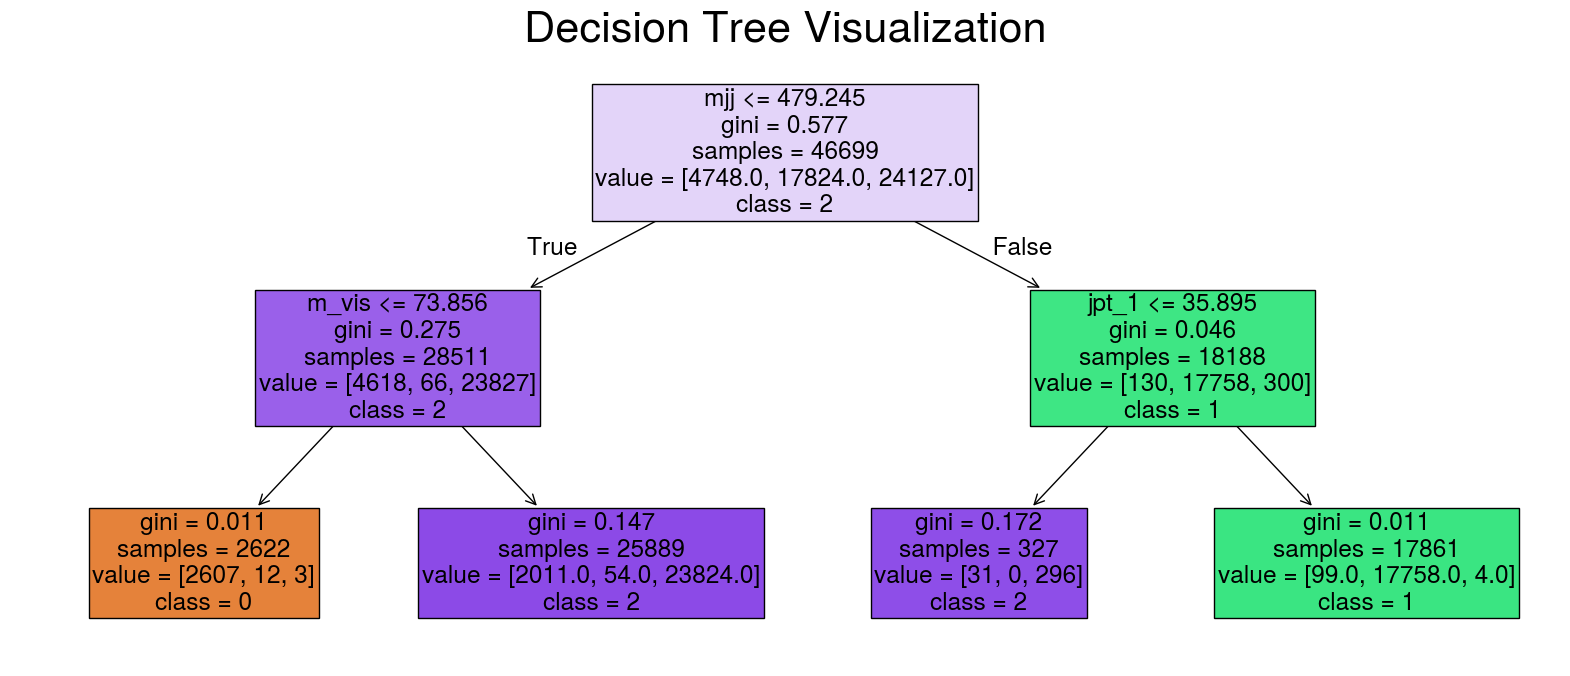

Accuracy of rule-based predictions: 0.95


In [52]:
selected_features_multi = loader(load = 'features', 
                                 model_filename = 'model_multi.pkl', 
                                 features_filename = 'features_multi.pkl')
print(selected_features_multi)
multi_filt = pd.read_csv('multi_filt.csv')
target = 'labels_encoded'

rule_tree = rule_maker(multi_filt, selected_features_multi, target, depth = 2)

We find that using `plot_tree()` and exporting the structure of the tree as text gives us a good representation of the decision rules. However, we would like the format to match the input format for `blf.fit()` from before.

While we could to parse through this tree ourselves and pick out the decision rules, we can write a function that does this for us, programmatically extracting the decision rules so that we can output them in the desired format:

In [53]:
def extract_rules(tree, feature_names, class_names, precision=2):
    """
    Extracts the decision rules from a decision tree classifier in a structured format, 
    organized by class, enablind them to be outputted in the format required by blf.fit()

    Parameters:
    tree: The fitted DecisionTreeClassifier() whose structure is to be parsed.

    feature_names: Names of the features used by the decision tree for splits.

    class_names: Names of the target classes. For example, ['DY', 'VBF', 'ggH'].

    precision: The number of decimal places to which the split thresholds are rounded.

    Output:
    - A dictionary where keys are class names and values are lists of rules.
      Each rule is represented as a list of conditions (e.g., ['feature1 <= threshold1', 'feature2 > threshold2']).
    """
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != -2 else "undefined!"
        for i in tree_.feature
    ]
    rules = {class_name: [] for class_name in class_names}

    def recurse(node, conditions):
        """
        Sub-function that recursively traverses the tree to extract decision rules for each class.

        Parameters:

        node: Current node index in the decision tree.

        conditions: The conditions accumulated along the path from the root to the current node.
        """
        if tree_.feature[node] != -2:  # If not a leaf node
            name = feature_name[node]
            threshold = round(tree_.threshold[node], precision)
            
            # Split into left and right branches
            left_conditions = conditions + [f"{name} <= {threshold}"]
            right_conditions = conditions + [f"{name} > {threshold}"]
            recurse(tree_.children_left[node], left_conditions)
            recurse(tree_.children_right[node], right_conditions)
        else:  # If a leaf node
            class_prediction = tree_.value[node].argmax()
            class_name = class_names[class_prediction]
            rules[class_name].append(conditions)

    recurse(0, [])
    return rules

In [54]:
class_names = list(map(str, rule_tree.classes_))
X_filt = multi_filt[selected_features_multi].copy()
rules_by_class = extract_rules(rule_tree, X_filt.columns.tolist(), class_names)

# Display rules for each class
for class_name, rules in rules_by_class.items():
    print(f"Class {class_name}:")
    for rule in rules:
        print(f"- {' & '.join(rule)}")

# Check against the plot of the tree itself
# plt.figure(figsize=(20, 8))
# plot_tree(rule_tree, feature_names=X_filt.columns, class_names=['DY', 'VBF', 'ggH'], filled=True)
# plt.show()

Class 0:
- mjj <= 479.24 & m_vis <= 73.86
Class 1:
- mjj > 479.24 & jpt_1 > 35.9
Class 2:
- mjj <= 479.24 & m_vis > 73.86
- mjj > 479.24 & jpt_1 <= 35.9


This, with depth-2 for e.g., gives us a few rules:
- Class 0:
    - mjj <= 479.24 & m_vis <= 73.86
- Class 1:
    - mjj > 479.24 & jpt_1 > 35.9
- Class 2:
    - mjj <= 479.24 & m_vis > 73.86
    - mjj > 479.24 & jpt_1 <= 35.9

These represent the set of rules that, if obeyed by a data point, allows us to confidently state that the particular decay in question originated from a given process. Note, we are **not** saying that the above model will work well for the overall dataset. Training on the reduced dataset and testing on the overall dataset might lead to poor results (in fact, it does). We are simply stating that these are the most significant set of criteria that can help distinguish the decays.

At depth-3, we get more complicated rules:

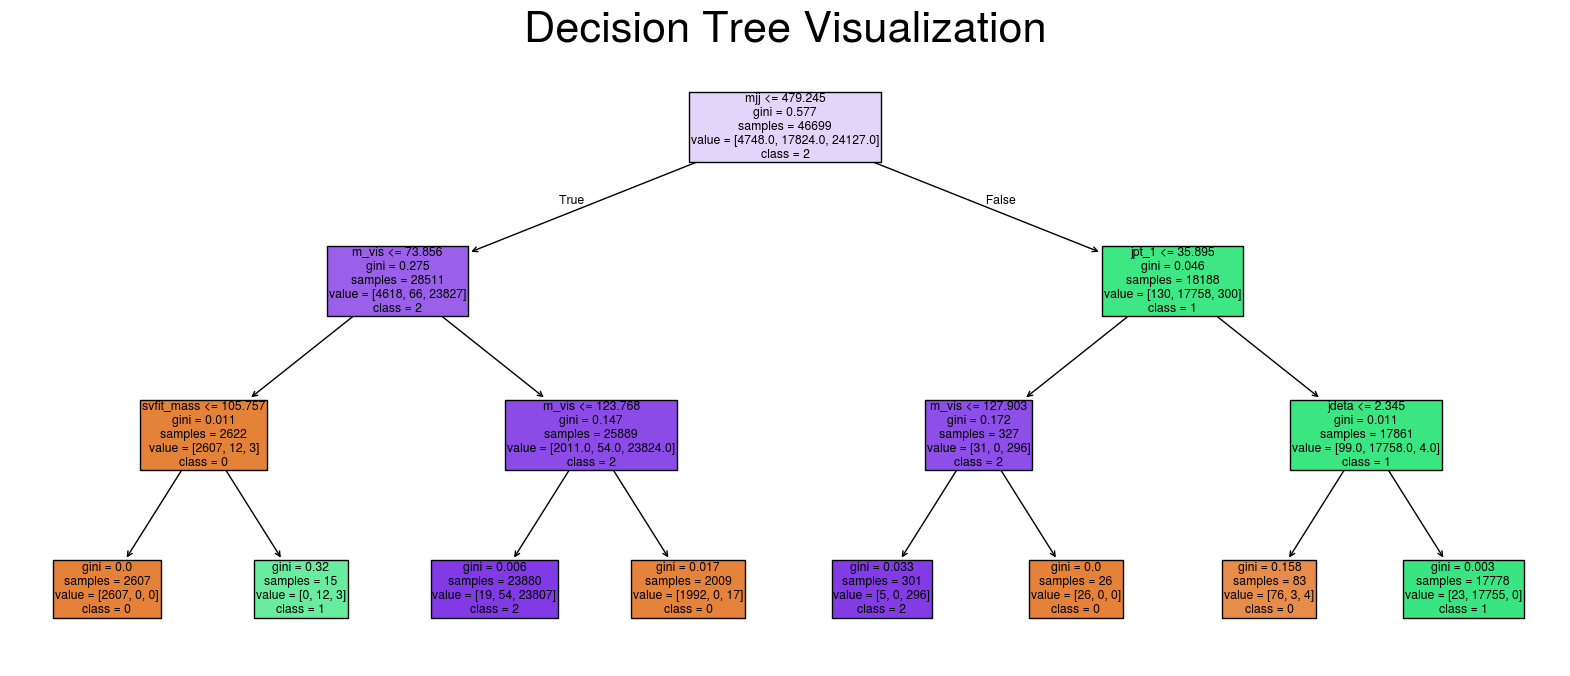

Accuracy of rule-based predictions: 1.00
Class 0:
- mjj <= 479.24 & m_vis <= 73.86 & svfit_mass <= 105.76
- mjj <= 479.24 & m_vis > 73.86 & m_vis > 123.77
- mjj > 479.24 & jpt_1 <= 35.9 & m_vis > 127.9
- mjj > 479.24 & jpt_1 > 35.9 & jdeta <= 2.35
Class 1:
- mjj <= 479.24 & m_vis <= 73.86 & svfit_mass > 105.76
- mjj > 479.24 & jpt_1 > 35.9 & jdeta > 2.35
Class 2:
- mjj <= 479.24 & m_vis > 73.86 & m_vis <= 123.77
- mjj > 479.24 & jpt_1 <= 35.9 & m_vis <= 127.9


In [55]:
rule_tree = rule_maker(multi_filt, selected_features_multi, target, depth = 3, out = True)
class_names = list(map(str, rule_tree.classes_))
rules_by_class = extract_rules(rule_tree, X_filt.columns.tolist(), class_names)
for class_name, rules in rules_by_class.items():
    print(f"Class {class_name}:")
    for rule in rules:
        print(f"- {' & '.join(rule)}")

We get:
- Class 0:
    - mjj <= 479.24 & m_vis <= 73.86 & svfit_mass <= 105.76
    - mjj <= 479.24 & m_vis > 73.86 & m_vis > 123.77
    - mjj > 479.24 & jpt_1 <= 35.9 & m_vis > 127.9
    - mjj > 479.24 & jpt_1 > 35.9 & jdeta <= 2.35
- Class 1:
    - mjj <= 479.24 & m_vis <= 73.86 & svfit_mass > 105.76
    - mjj > 479.24 & jpt_1 > 35.9 & jdeta > 2.35
- Class 2:
    - mjj <= 479.24 & m_vis > 73.86 & m_vis <= 123.77
    - mjj > 479.24 & jpt_1 <= 35.9 & m_vis <= 127.9

The set of rules at depth-3 are more complex than those above, but are more specific in terms of the region they describe in the feature space. We also see that there is some overlap and redudancy in how the classifier established the decision rules as the depth is increased. An example is the second rule for Class 0.

We can select one or more of these and define an orthogonal region to be everything outside of the region bounded by the variables in the given criterion. 

## Section 5: Binned Likelihood Fitting

We are now in a position to consider the `BinnedLikelihoodFit` class from before. We can use these decision rules to inform our choice of categories and variables.

From the discussion on decision rules above, we find that the decision rules VBF seems to be good discriminator in the sense that it seems to occupy the least number of leaves (at least up to depth-3). More generically, we might be interested in distinguishing between background and signal. If so, we can consider the rules for VBF and ggH in conjunction, merging them with 'or', for example.

As a simple trial, let us the depth-3 rules for VBF to define our orthogonal categories. We will use our filtered dataset from which we derived our decision rules.

In [18]:
overall_data_multi = pd.read_csv('overall_data_multi.csv')
probs_save = overall_data_multi[overall_data_multi.columns[-5:]]
probs_save.to_csv('pred_probs.csv',  sep = ',', index = False, encoding = 'utf-8')
# print(selected_features_multi.to_list())
# overall_features = selected_features_multi.to_list() + ['prob_0', 'prob_1', 'prob_2']
# data_DY = overall_data_multi[overall_features][overall_data_multi['label'] == 'DY']
# display(data_DY)
# data_VBF = overall_data_multi[overall_features][overall_data_multi['label'] == 'VBF']
# data_ggH = overall_data_multi[overall_features][overall_data_multi['label'] == 'ggH']

In [88]:
blf = BinnedLikelihoodFit(data_DY, data_VBF, data_ggH)

Now, we can use the probability of an event being classified as DY (the background) as the variable on which to split when performing the binned likelihood fit. This approach helps us discern whether a given event corresponds to the production of a Higgs boson (signal) or not (background). In other words, the probability of being classified as DY serves as a useful metric for identifying potential signal events, as these are expected to deviate from the background classification.

We can further consider the regions of the histograms where there is a discernably greater freqeuncy of signal events as compared to background events. This allows us to focus on a particular range of probabilities and apply different types of binning over such intervals to calculate the precision metrics we are interest in minimising.

We are certain that advanced binning techniques exist that can automate the determination of a suitable binning strategy over the probability distributions. However, through simple trial-and-error, we found the following results:

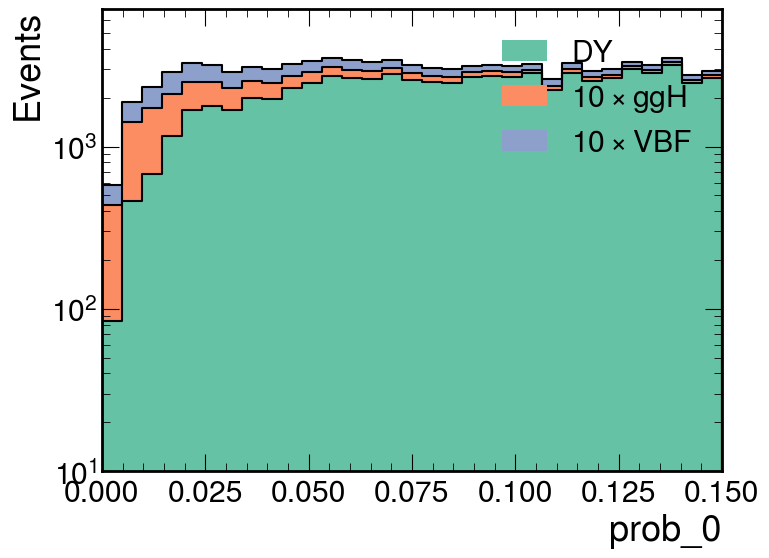

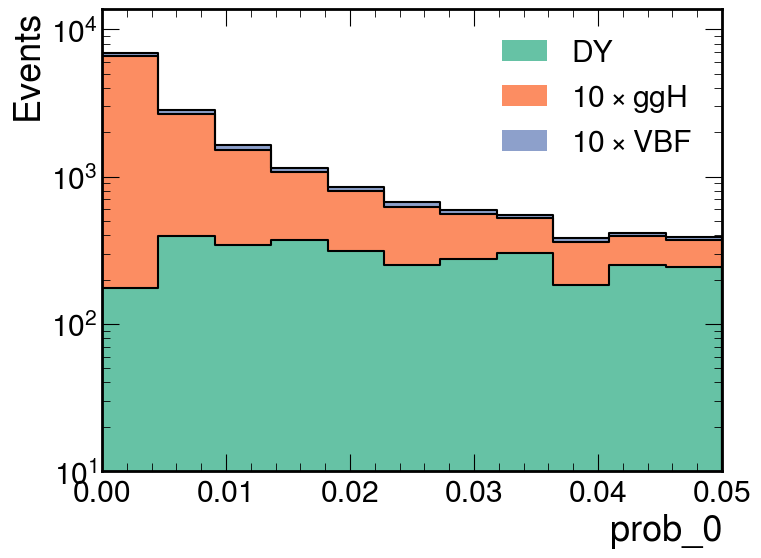

-----------------------------------------
Split Signal Strength Fit Results:
mu_ggH = 1.0 ± 0.0602
mu_VBF = 1.0 ± 0.2701
Precision:
mu_ggH:  6.02%
mu_VBF:  27.01%
-----------------------------------------

-----------------------------------------
Inclusive Signal Strength Fit Results:
mu = 1.0 ± 0.048
Precision:
mu:  4.8%
-----------------------------------------



In [112]:
# Class 1 (VBF)
# mjj > 483.29 & jpt_1 > 39.74 & jdeta > 2.22

variables = ["prob_0", 'prob_0']
bins = [np.linspace(0.0, 0.15,num = 32), np.linspace(0.0, 0.05,num=12)]
categories = ['not (mjj > 479.24 & jpt_1 > 35.9)',
              '(mjj > 479.24 & jpt_1 > 35.9)']
precision_mu_split = blf.fit(variables, bins, categories, method="split")
precision_mu_inclusive = blf.fit(variables, bins, categories, method="inclusive", plot = False)

We find results that already beat 2 out of the 3 metrics reported by CMS, by quite significant amounts, and the remaining metric shows a noticable improvement over the baseline solutions presented before. We have managed to achieve this through a very simple, brute-force, trial-and-error approach for our binning.

## Section 6: Conclusions

### **Summary**
In this report, we have analysed a simulated dataset of particle decays with the aim of developing a framework that can accurately detect the production of Higgs bosons (the signal). Our approach focuses on determining the minimal set of features that can best distinguish between different types of particle decays. Our entire workflow is summarised as follows:

**Pre-processing:**
- We considered an aggregated dataset with imbalanced counts of events from each decay process involved and we tagged our events with the processes that gave rise to them.

**ML Setup and Feature Selection**
- We adopted a multiclass classification setup, and trained `XGBClassifier` models on our data, using the class labels as targets and the remaining parameters of the events as features/predictors. Furthermore, we ensured the usage of machine learning techniques to handle imbalanced multiclass problems like ours.
- Initially, we used the classifier in conjunction with RFECV to eliminate some features that did not contribute heavily to the classification decisions.
- We also trained an unconfigured classifier on our entire dataset, and considered the features ranked by importance (based on the 'gain' metric), comparing this ranking to the one returned by RFECV.
- We found that the highest ranked features showed consistent rankings across both runs.
- We assessed the effects of further manual feature removal on model performance and feature ranking, finding no significant loss in model performance and only minor discrepancies in ranking. This resulted in a significantly downsized dataset for further analysis.

**Model Tuning and Class Probabilities**
- We performed hyperparameter tuning using `Optuna` to optimise the performance of our classifier on the downsized dataset.
- We fitted the trained and fine-tuned model on the entire downsized dataset to predict the class probabilities for each event. We added these predictionsas new features to our overall dataset.

**Decision Rules**
- We roughly mapped the feature space coverage for each class using the class probabilities, focusing on events to which the model confidently and accurately assigned the correct label.
- To overcome the inherent complexities associated with `XGBClassifier()`, we used a simple `DecisionTreeClassifier()` to derive interpretable decision rules that can distinguish between the target classes.

**Binned Likehood Fitting and Parameter Estimation**
- We used the decision rules obtained for the VBF class of decays to establish orthogonal categories for the binned likelihood fitting procedure.
- We chose the probability of being classed as background (DY) as the variable on which to perform the split because this is a useful metric for identifying potential signal events, which are expected to deviate from the background classification.
- We limitied our fitting procedure to one set of categories and variables, adopting a simple brute-force approach to minimise the precisions of the $\mu$ parameters of the fit.
- We achieved high precisions on the required parameters, surpassing the 2/3 precisions reported by CMS, with the precision in the 3rd feature showing marked improvement over the baseline solution.

### **Next Steps**
There is substantial room for improvement in our methodology, especially in the binning and fitting portion of our analysis. While we believe that our approach to determining decision rules follows sound logic, we are certain that far superior binning methods exist, that we have not been able to implement here. Using a brute-force iterative approach for binning frequencies, similar to a grid search, is a natural choice. 

Further expansion of this work could involve either a detailed visual analysis of class distributions in the final dataset, or the use of an ML model to automatically optimise the binning choice, among other options.

Experimenting with several other category-variable combinations may lead to greater insight into the detection of potential signal events. We have selected the simplest, most-discerning configuration based on our judgement, and yielded relatively good results.

Other ML models, such as SVMs or NNs, may offer better alternatives to our classifier-based approach in determining decision boundaries and their associated rules. This needs to be verified practically, but we believe that tree-based models, like the ones used here, strike an ideal balance between interpretability and complexity, making them suitable for such analyses.

An equally valid, though less interpretable and potentially more powerful, approach to feature selection could involve using PCA, which might further simplify the feature set and the resulting decision rules. We recommend investigating the effects of combining PCA with RFECV for such analyses.

We have deliberately made our code robust and adaptable, allowing it to be applicable to other problems of a similar nature. As an example, although a simpler model-tuning strategy could have been used, `Optuna` generalizes well to larger datasets with more features.

We have generated several files, models and feature sets, all of which may be found on the GitHub [repo](https://github.com/farhansharif75/HiggsOptmisation) for this project (updloaded after project deadline). This brings us to the end of this notebook.